# 0. Datasets Variable Descriptions

## ⚡ Energy Dataset Variables

The energy dataset contains hourly electricity generation values by source, load information, and market price.

---

##### 🔋 Generation Variables (Energy Produced by Each Source)

**`generation_biomass`**  
Electricity produced from biomass combustion. Renewable but dispatchable, with moderate cost.

**`generation_fossil_brown_coal_lignite`**  
Electricity generated from lignite-fired plants. Cheap but polluting baseload source.

**`generation_fossil_coal-derived_gas`**  
Electricity produced from gases derived from coal processing. Less common and relatively high-cost.

**`generation_fossil_gas`**  
Generation from natural gas plants. Often the marginal price setter in European electricity markets.

**`generation_fossil_hard_coal`**  
Electricity from hard coal plants. Used mainly as baseload or mid-merit generation.

**`generation_fossil_oil`**  
Electricity produced from oil-based power plants. Very expensive; typically dispatched only during peak hours.

**`generation_fossil_oil_shale`**  
Electricity produced from oil shale combustion. Rare and high-cost.

**`generation_fossil_peat`**  
Electricity produced from peat combustion. Similar to coal but with lower energy density.

**`generation_geothermal`**  
Electricity generated from geothermal heat sources. Stable, renewable, and typically low marginal cost.

---

##### 💧 Hydro Generation Variables

**`generation_hydro_pumped_storage_aggregated`**
Electricity generated by pumped-storage hydro plants during discharge.

**`generation_hydro_pumped_storage_consumption`**  
Electricity consumed during pumping operations. Represents energy used to store water.

**`generation_hydro_run-of-river_and_poundage`**  
Electricity produced from run-of-river hydro plants, highly dependent on river flow.

**`generation_hydro_water_reservoir`**  
Generation from hydroelectric reservoirs. Used strategically during high-price periods.

---

##### ☢️ Other Generation Sources

**`generation_marine`**  
Electricity produced from marine energy sources (waves/tides). Rare and experimental.

**`generation_nuclear`**  
Stable baseload electricity from nuclear plants. Very low marginal cost.

**`generation_other`**  
Electricity generated from unspecified sources.

**`generation_other_renewable`**  
Renewable energy not classified into other specific categories.

**`generation_solar`**  
Electricity generated from solar photovoltaic systems. Highly dependent on sunlight and time of day.

**`generation_waste`**  
Electricity produced from waste incineration.

**`generation_wind_offshore`**  
Electricity generated by offshore wind farms. Typically more stable winds and higher output.

**`generation_wind_onshore`**  
Electricity produced from onshore wind turbines. More variable due to local wind patterns.

---

##### 🌬 Forecast Variable

**`forecast_wind_offshore_eday_ahead`**  
Day-ahead forecast of offshore wind generation. Forecast accuracy influences expected market prices.

---

##### 🔌 Load / Demand Variable

**`total_load_actual`**  
Measured hourly electricity demand. A primary driver of electricity prices — higher load usually increases price.

---

##### 💶 Price Variable (Target)

**`price_day_ahead`**  
The day-ahead hourly electricity price. This is the **target variable** for prediction in the project.


## 🌦 Weather Dataset Variables

The weather dataset provides hourly meteorological conditions that influence electricity demand and renewable generation.

---

##### 🌡 Temperature

**`temperature`**  
Air temperature. Strongly influences heating and cooling demand, and therefore total electricity consumption.

---

##### 🧭 Atmospheric Pressure

**`pressure`**  
Atmospheric pressure. Useful for identifying weather systems that affect wind availability.

---

##### 💧 Humidity

**`humidity`**  
Relative humidity of the air. Provides atmospheric context but has indirect influence on electricity systems.

---

##### 🌬 Wind

**`wind_speed`**  
Wind speed at the measurement location. Directly affects wind power production levels and therefore supply conditions in the electricity market.

# 1. Data understanding and preparation

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", None)

energy = pd.read_csv("Dataset/energy_dataset.csv", parse_dates=["time"], index_col="time")
weather = pd.read_csv("Dataset/weather.csv", parse_dates=["time"], index_col="time")

energy.head(), weather.head()

(                           generation_biomass  \
 time                                            
 2015-01-01 00:00:00+01:00               447.0   
 2015-01-01 01:00:00+01:00               449.0   
 2015-01-01 02:00:00+01:00               448.0   
 2015-01-01 03:00:00+01:00               438.0   
 2015-01-01 04:00:00+01:00               428.0   
 
                            generation_fossil_brown_coal_lignite  \
 time                                                              
 2015-01-01 00:00:00+01:00                                 329.0   
 2015-01-01 01:00:00+01:00                                 328.0   
 2015-01-01 02:00:00+01:00                                 323.0   
 2015-01-01 03:00:00+01:00                                 254.0   
 2015-01-01 04:00:00+01:00                                 187.0   
 
                            generation_fossil_coal-derived_gas  \
 time                                                            
 2015-01-01 00:00:00+01:00            

### Checking the datasets shape

In [2]:
print("Energy shape:", energy.shape)
print("Weather shape:", weather.shape)

energy.info()
weather.info()

Energy shape: (35064, 24)
Weather shape: (35064, 4)
<class 'pandas.core.frame.DataFrame'>
Index: 35064 entries, 2015-01-01 00:00:00+01:00 to 2018-12-31 23:00:00+01:00
Data columns (total 24 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation_biomass                           35045 non-null  float64
 1   generation_fossil_brown_coal_lignite         35046 non-null  float64
 2   generation_fossil_coal-derived_gas           35046 non-null  float64
 3   generation_fossil_gas                        35046 non-null  float64
 4   generation_fossil_hard_coal                  35046 non-null  float64
 5   generation_fossil_oil                        35045 non-null  float64
 6   generation_fossil_oil_shale                  35046 non-null  float64
 7   generation_fossil_peat                       35046 non-null  float64
 8   generation_geothermal                        35046 non-

In [3]:
#remover colunas sem valor relevante
cols_to_drop = ['generation_hydro_pumped_storage_aggregated', 'forecast_wind_offshore_eday_ahead']
energy = energy.drop(columns=cols_to_drop)

### Checking the datasets statistics

In [4]:
energy.describe()

generation_biomass  generation_fossil_brown_coal_lignite  \
count        35045.000000                          35046.000000   
mean           383.513540                            448.059208   
std             85.353943                            354.568590   
min              0.000000                              0.000000   
25%            333.000000                              0.000000   
50%            367.000000                            509.000000   
75%            433.000000                            757.000000   
max            592.000000                            999.000000   

       generation_fossil_coal-derived_gas  generation_fossil_gas  \
count                             35046.0           35046.000000   
mean                                  0.0            5622.737488   
std                                   0.0            2201.830478   
min                                   0.0               0.000000   
25%                                   0.0            4126.000000   
50%                                   0.0            4969.000000   
75%                                   0.0            6429.000000   
max                                   0.0           20034.000000   

       generation_fossil_hard_coal  generation_fossil_oil  \
count                 35046.000000           35045.000000   
mean                   4256.065742             298.319789   
std                    1961.601013              52.520673   
min                       0.000000               0.000000   
25%                    2527.000000             263.000000   
50%                    4474.000000             300.000000   
75%                    5838.750000             330.000000   
max                    8359.000000             449.000000   

       generation_fossil_oil_shale  generation_fossil_peat  \
count                      35046.0                 35046.0   
mean                           0.0                     0.0   
std                            0.0                     0.0   
min                            0.0                     0.0   
25%                            0.0                     0.0   
50%                            0.0                     0.0   
75%                            0.0                     0.0   
max                            0.0                     0.0   

       generation_geothermal  generation_hydro_pumped_storage_consumption  \
count                35046.0                                 35045.000000   
mean                     0.0                                   475.577343   
std                      0.0                                   792.406614   
min                      0.0                                     0.000000   
25%                      0.0                                     0.000000   
50%                      0.0                                    68.000000   
75%                      0.0                                   616.000000   
max                      0.0                                  4523.000000   

       generation_hydro_run-of-river_and_poundage  \
count                                35045.000000   
mean                                   972.116108   
std                                    400.777536   
min                                      0.000000   
25%                                    637.000000   
50%                                    906.000000   
75%                                   1250.000000   
max                                   2000.000000   

       generation_hydro_water_reservoir  generation_marine  \
count                      35046.000000            35045.0   
mean                        2605.114735                0.0   
std                         1835.199745                0.0   
min                            0.000000                0.0   
25%                         1077.250000                0.0   
50%                         2164.000000                0.0   
75%                         3757.000000                0.0   
max          

In [5]:
weather.describe()

temperature      pressure      humidity    wind_speed
count  35064.000000  35064.000000  35064.000000  35064.000000
mean     289.706862   1017.297872     68.033025      2.442944
std        7.251796      6.363845     14.814871      1.276415
min      272.006000    999.500000     22.600000      0.000000
25%      284.098877   1013.475000     56.750000      1.400000
50%      289.036200   1017.000000     69.600000      2.200000
75%      295.100500   1021.000000     80.000000      3.200000
max      309.048000   1035.500000    100.000000      8.500000

### Checking for null/missing values

In [6]:
summary = pd.DataFrame({
    'percent_null': energy.isna().mean() * 100,
    'percent_zero': (energy == 0).mean() * 100
})

summary

percent_null  percent_zero
generation_biomass                               0.054187      0.011408
generation_fossil_brown_coal_lignite             0.051335     29.993726
generation_fossil_coal-derived_gas               0.051335     99.948665
generation_fossil_gas                            0.051335      0.002852
generation_fossil_hard_coal                      0.051335      0.008556
generation_fossil_oil                            0.054187      0.008556
generation_fossil_oil_shale                      0.051335     99.948665
generation_fossil_peat                           0.051335     99.948665
generation_geothermal                            0.051335     99.948665
generation_hydro_pumped_storage_consumption      0.054187     35.954255
generation_hydro_run-of-river_and_poundage       0.054187      0.008556
generation_hydro_water_reservoir                 0.051335      0.008556
generation_marine                                0.054187     99.945813
generation_nuclear                               0.048483      0.008556
generation_other                                 0.051335      0.011408
generation_other_renewable                       0.051335      0.008556
generation_solar                                 0.051335      0.008556
generation_waste                                 0.054187      0.008556
generation_wind_offshore                         0.051335     99.948665
generation_wind_onshore                          0.051335      0.008556
total_load_actual                                0.102669      0.000000
price_day_ahead                                  0.000000      0.000000

In [7]:
#remover colunas só com valores 0 ou null
cols_zero_or_null = [
    col for col in energy.columns
    if (energy[col].isna() | (energy[col] == 0)).all()
]

cols_zero_or_null

#remover essas colunas
energy = energy.drop(columns=cols_zero_or_null)

In [8]:
summary = pd.DataFrame({
    'percent_null': weather.isna().mean() * 100,
    'percent_zero': (weather == 0).mean() * 100
})

summary

percent_null  percent_zero
temperature           0.0      0.000000
pressure              0.0      0.000000
humidity              0.0      0.000000
wind_speed            0.0      0.005704

### Checking for duplicated indexes

In [9]:
print("Duplicated timestamps in energy:", energy.index.duplicated().sum())
print("Duplicated timestamps in weather:", weather.index.duplicated().sum())

Duplicated timestamps in energy: 0
Duplicated timestamps in weather: 0


### Verify temporal alignment

In [10]:
print("Energy:", energy.index.min(), " -> ", energy.index.max())
print("Weather:", weather.index.min(), " -> ", weather.index.max())

Energy: 2015-01-01 00:00:00+01:00  ->  2018-12-31 23:00:00+01:00
Weather: 2015-01-01 00:00:00+01:00  ->  2018-12-31 23:00:00+01:00


In [11]:
# 1. Criar a sequência completa esperada (de hora a hora)
full_range = pd.date_range(start=energy.index.min(),
                           end=energy.index.max(),
                           freq='h')

# 2. Encontrar os timestamps que faltam
missing = full_range.difference(energy.index)

# 3. Ver quantos faltam e quais são
print(f"Total de horas em falta: {len(missing)}")
print("\nPrimeiros timestamps em falta:")
print(missing[:10]) 


# 1. Criar a sequência completa esperada (de hora a hora)
full_range = pd.date_range(start=weather.index.min(),
                           end=weather.index.max(),
                           freq='h')

# 2. Encontrar os timestamps que faltam
missing = full_range.difference(weather.index)

# 3. Ver quantos faltam e quais são
print(f"\nTotal de horas em falta: {len(missing)}")
print("\nPrimeiros timestamps em falta:")
print(missing[:10]) 



Total de horas em falta: 0

Primeiros timestamps em falta:
DatetimeIndex([], dtype='datetime64[ns, UTC+01:00]', freq='h')

Total de horas em falta: 0

Primeiros timestamps em falta:
DatetimeIndex([], dtype='datetime64[ns, UTC+01:00]', freq='h')


### Joining the datasets by time index

In [12]:
df = energy.join(weather, how="inner")
df.shape

(35064, 20)

In [13]:
df.describe()

generation_biomass  generation_fossil_brown_coal_lignite  \
count        35045.000000                          35046.000000   
mean           383.513540                            448.059208   
std             85.353943                            354.568590   
min              0.000000                              0.000000   
25%            333.000000                              0.000000   
50%            367.000000                            509.000000   
75%            433.000000                            757.000000   
max            592.000000                            999.000000   

       generation_fossil_gas  generation_fossil_hard_coal  \
count           35046.000000                 35046.000000   
mean             5622.737488                  4256.065742   
std              2201.830478                  1961.601013   
min                 0.000000                     0.000000   
25%              4126.000000                  2527.000000   
50%              4969.000000                  4474.000000   
75%              6429.000000                  5838.750000   
max             20034.000000                  8359.000000   

       generation_fossil_oil  generation_hydro_pumped_storage_consumption  \
count           35045.000000                                 35045.000000   
mean              298.319789                                   475.577343   
std                52.520673                                   792.406614   
min                 0.000000                                     0.000000   
25%               263.000000                                     0.000000   
50%               300.000000                                    68.000000   
75%               330.000000                                   616.000000   
max               449.000000                                  4523.000000   

       generation_hydro_run-of-river_and_poundage  \
count                                35045.000000   
mean                                   972.116108   
std                                    400.777536   
min                                      0.000000   
25%                                    637.000000   
50%                                    906.000000   
75%                                   1250.000000   
max                                   2000.000000   

       generation_hydro_water_reservoir  generation_nuclear  generation_other  \
count                      35046.000000        35047.000000      35046.000000   
mean                        2605.114735         6263.907039         60.228585   
std                         1835.199745          839.667958         20.238381   
min                            0.000000            0.000000          0.000000   
25%                         1077.250000         5760.000000         53.000000   
50%                         2164.000000         6566.000000         57.000000   
75%                         3757.000000         7025.000000         80.000000   
max                         9728.000000         7117.000000        106.000000   

       generation_other_renewable  generation_solar  generation_waste  \
count                35046.000000      35046.000000      35045.000000   
mean                    85.639702       1432.665925        269.452133   
std                     14.077554       1680.119887         50.195536   
min                      0.000000          0.000000          0.000000   
25%                     73.000000         71.000000        240.000000   
50%                     88.000000        616.000000        279.000000   
75%                     97.000000       2578.000000        310.000000   
max                    119.000000       5792.000000        357.000000   

       generation_wind_onshore  total_load_actual  price_day_ahead  \
count             35046.000000       35028.000000     35064.000000   
mean               5464.479769       28696.939905        49.874341   
std                3213.691587        4574.987950        14.618900   
min          

### Setting target variable (price)

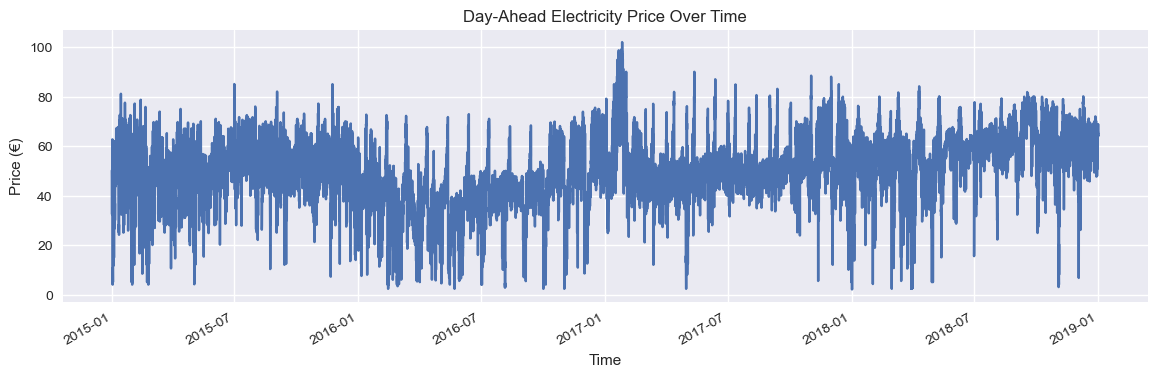

In [14]:
target = "price_day_ahead"

df[target].plot(figsize=(14,4))
plt.title("Day-Ahead Electricity Price Over Time")
plt.xlabel("Time")
plt.ylabel("Price (€)")
plt.show()

### Target variable correlations

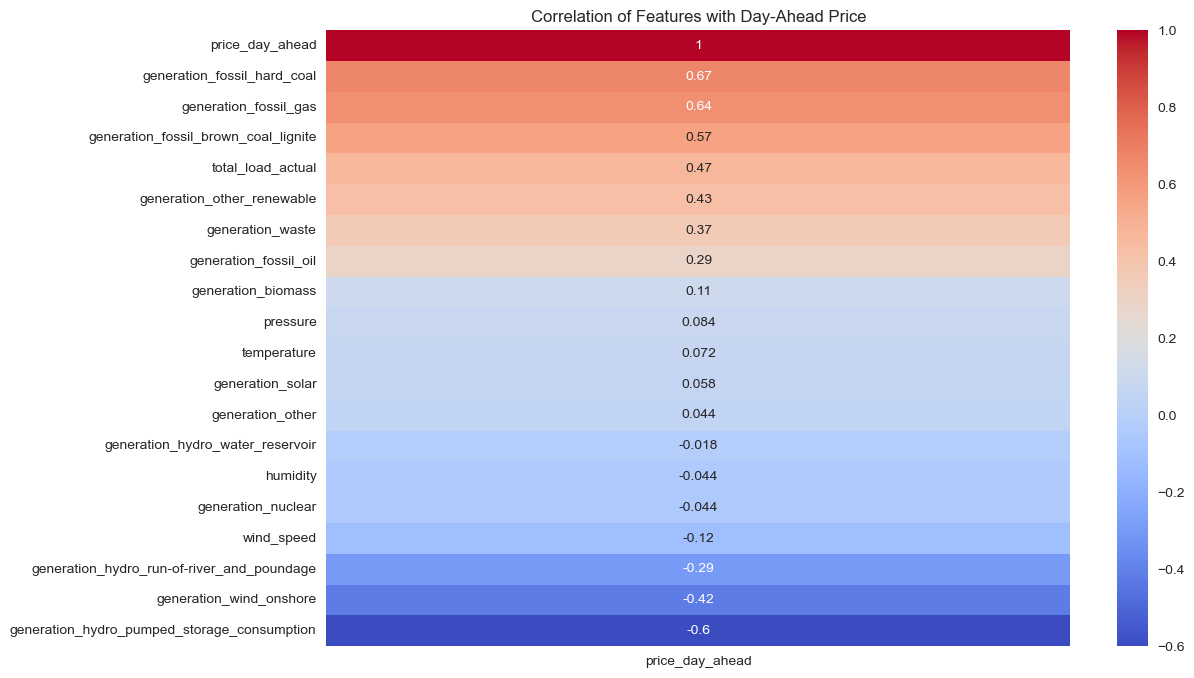

In [15]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True)[[target]].sort_values(by=target, ascending=False), 
            cmap="coolwarm", annot=True)
plt.title("Correlation of Features with Day-Ahead Price")
plt.show()

In [16]:
df.corr(numeric_only=True)[[target]].sort_values(by=target, ascending=False).head(20)

price_day_ahead
price_day_ahead                                     1.000000
generation_fossil_hard_coal                         0.671596
generation_fossil_gas                               0.640895
generation_fossil_brown_coal_lignite                0.567905
total_load_actual                                   0.473869
generation_other_renewable                          0.428078
generation_waste                                    0.368036
generation_fossil_oil                               0.292793
generation_biomass                                  0.108945
pressure                                            0.084098
temperature                                         0.071707
generation_solar                                    0.058392
generation_other                                    0.043599
generation_hydro_water_reservoir                   -0.017807
humidity                                           -0.043658
generation_nuclear                                 -0.044189
wind_speed                                         -0.117201
generation_hydro_run-of-river_and_poundage         -0.294718
generation_wind_onshore                            -0.424899
generation_hydro_pumped_storage_consumption        -0.600460

In [17]:
df.index = pd.to_datetime(df.index, utc=True).tz_convert(None)
df = df.sort_index()

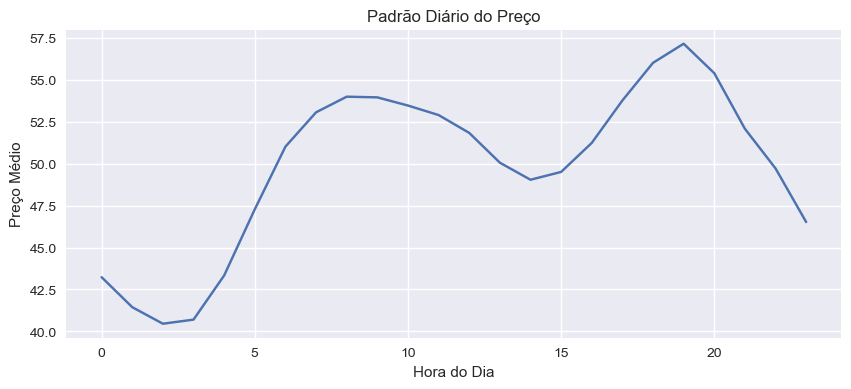

In [18]:
df['hour'] = df.index.hour
df.groupby('hour')['price_day_ahead'].mean().plot(figsize=(10,4))
plt.title("Padrão Diário do Preço")
plt.xlabel("Hora do Dia")
plt.ylabel("Preço Médio")
plt.show()

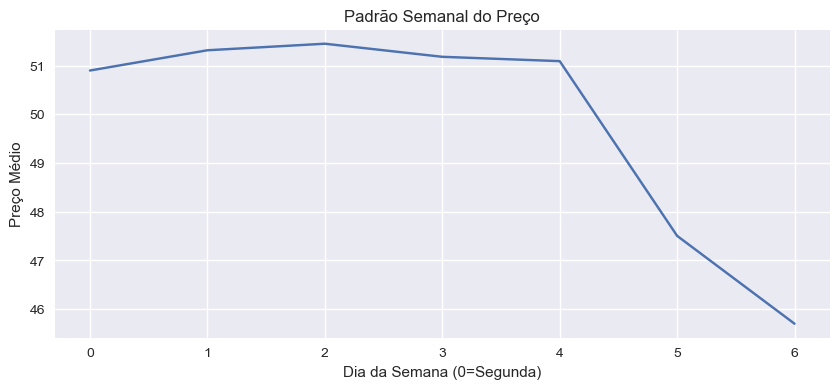

In [19]:
df['weekday'] = df.index.weekday
df.groupby('weekday')['price_day_ahead'].mean().plot(figsize=(10,4))
plt.title("Padrão Semanal do Preço")
plt.xlabel("Dia da Semana (0=Segunda)")
plt.ylabel("Preço Médio")
plt.show()


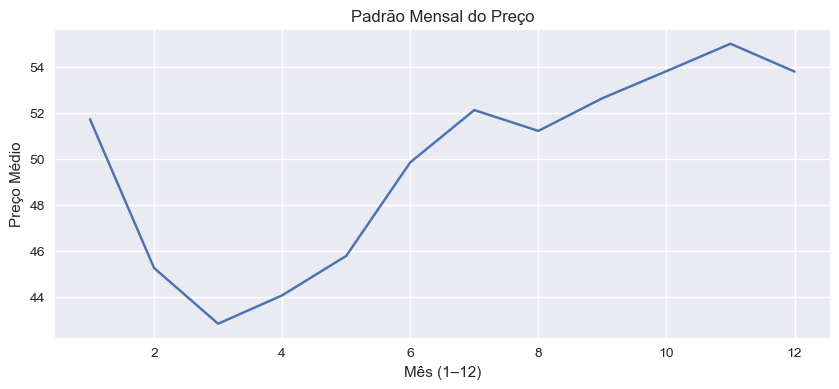

In [20]:
df['month'] = df.index.month

df.groupby('month')['price_day_ahead'].mean().plot(figsize=(10,4))
plt.title("Padrão Mensal do Preço")
plt.xlabel("Mês (1–12)")
plt.ylabel("Preço Médio")
plt.show()

In [21]:
df = df.drop(['hour', 'weekday', 'month'], axis=1)

# 2. Data pre-processing

In [22]:
# modelo para as statisticals
df_stat = df.copy()
df_stat = df_stat.ffill().bfill()

# Treino: 2016-01-01 até 2017-12-31
# Teste:  2018-01-01 até 2018-12-31
train_stat = df_stat.loc['2016-01-01':'2017-12-31'].asfreq('h')
test_stat  = df_stat.loc['2018-01-01':'2018-12-31'].asfreq('h')

print(train_stat.shape, test_stat.shape)
print(train_stat.index.min(), train_stat.index.max())

(17544, 20) (8759, 20)
2016-01-01 00:00:00 2017-12-31 23:00:00


In [23]:
df_ml = df.copy()

# interpolar apenas buracos simples
df_ml = df_ml.interpolate(method='linear')

# features temporais
df_ml['hour_of_day'] = df_ml.index.hour
df_ml['day_of_week'] = df_ml.index.weekday
df_ml['month'] = df_ml.index.month
df_ml['is_weekend'] = (df_ml.index.weekday >= 5).astype(int)

# target
target = 'price_day_ahead'

# lags e rolling features
df_ml['lag_1'] = df_ml[target].shift(1)
df_ml['lag_24'] = df_ml[target].shift(24)
df_ml['rolling_6h'] = df_ml[target].rolling(6).mean()
df_ml['mean_24'] = df_ml[target].rolling(24).mean()
df_ml['rolling_72h'] = df_ml[target].rolling(72).mean()
df_ml['std_24h'] = df_ml[target].rolling(24).std()
# remover linhas com NaN resultantes das features de lag/rolling
df_ml = df_ml.dropna()

# -------------------------
# NORMALIZAÇÃO (só features)
# -------------------------
from sklearn.preprocessing import MinMaxScaler

feature_cols = df_ml.columns.drop(target)

scaler = MinMaxScaler()
df_ml_scaled = df_ml.copy()
df_ml_scaled[feature_cols] = scaler.fit_transform(df_ml[feature_cols])

# -------------------------
# SPLIT TREINO / TESTE
# -------------------------
train_ml = df_ml_scaled.loc[:'2017-12-31']
test_ml  = df_ml_scaled.loc['2018-01-01':]

# 3. Modelling: creation of models to predict electricity price 1-step ahead and 24-step ahead (one day).


## Statistical Models

In [24]:
##parte 3
# exemplo: usar 2016-01-01 até 2017-12-31 para treino estatístico
target = 'price_day_ahead'

# correlação absoluta das variáveis com o target
correlations = train_stat.corr()[target].abs().sort_values(ascending=False)
print(correlations)

# threshold mínimo
threshold = 0.5

# colunas que ficam
keep_cols = correlations[correlations >= threshold].index.tolist()

# garantir que o target fica sempre
if target not in keep_cols:
    keep_cols.append(target)

# reduzir train e test
train_stat = train_stat[keep_cols]
test_stat  = test_stat[keep_cols]

# endógena
y_train = train_stat[target]
y_test  = test_stat[target]

# exógenas = todas as colunas exceto o target
exog_cols = [col for col in train_stat.columns if col != target]

exog_train = train_stat[exog_cols]
exog_test  = test_stat[exog_cols]

print("Target:", target)
print("Exógenas:", exog_cols)
print("Train shape:", train_stat.shape)
print("Test shape:", test_stat.shape)

price_day_ahead                                1.000000
generation_fossil_hard_coal                    0.777618
generation_fossil_gas                          0.701565
generation_fossil_brown_coal_lignite           0.684793
generation_other_renewable                     0.676262
generation_waste                               0.543888
generation_hydro_pumped_storage_consumption    0.530677
generation_hydro_run-of-river_and_poundage     0.522145
total_load_actual                              0.471185
generation_wind_onshore                        0.373784
generation_fossil_oil                          0.240644
generation_hydro_water_reservoir               0.191618
wind_speed                                     0.136445
pressure                                       0.133569
generation_other                               0.086570
temperature                                    0.064744
generation_nuclear                             0.059537
generation_biomass                             0

ADF


In [25]:
result = adfuller(y_train)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -7.4144001106247375
p-value: 6.99695025227768e-11


ACF/PACF

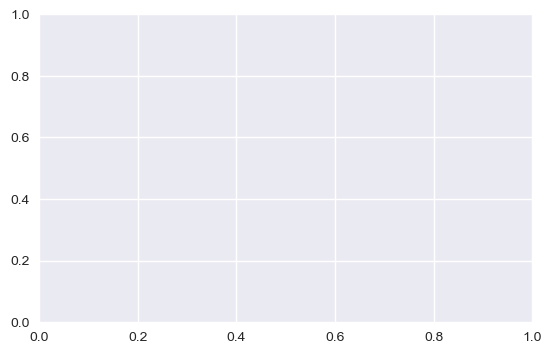

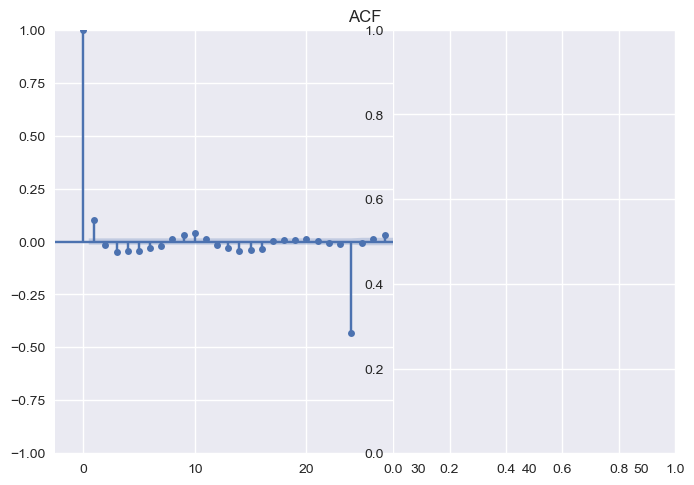

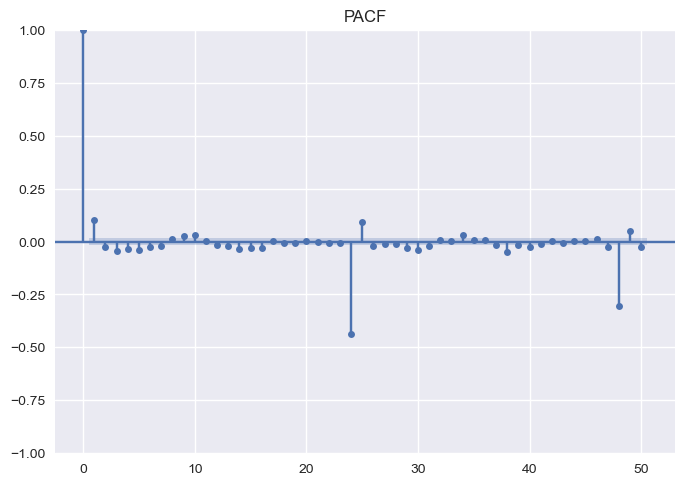

In [26]:
# differencing para visualizar melhor
y_diff = y_train.diff().dropna()
y_seasonal = y_diff.diff(24).dropna()

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plot_acf(y_seasonal, lags=50)
plt.title("ACF")

plt.subplot(1,2,2)
plot_pacf(y_seasonal, lags=50)
plt.title("PACF")

plt.show()

SARIMA (AIC)

In [27]:
# 1) subset pequeno para busca de parâmetros
# y_search = y_train.iloc[:24*90]  # 3 meses, por exemplo

# # 2) grid reduzido
# p = q = [0, 1]
# d = 0   # ADF mostrou estacionaridade
# D = 1
# seasonal_period = 24

# pdq = list(itertools.product(p, [d], q))
# seasonal_pdq = [(x[0], D, x[2], seasonal_period)
#                 for x in itertools.product([0,1], [1], [0,1])]

# best_aic = np.inf
# best_order = None
# best_seasonal = None

# for order in pdq:
#     for s_order in seasonal_pdq:
#         try:
#             model = SARIMAX(
#                 y_search,
#                 order=order,
#                 seasonal_order=s_order,
#                 enforce_stationarity=False,
#                 enforce_invertibility=False
#             )
#             results = model.fit(disp=False)
#             if results.aic < best_aic:
#                 best_aic = results.aic
#                 best_order = order
#                 best_seasonal = s_order
#         except Exception:
#             continue

# print("Best SARIMA parameters:", best_order, best_seasonal, "AIC:", best_aic)

#Best SARIMA parameters: (1, 0, 1) (1, 1, 1, 24) AIC: 11629.21478561428

# 3) refitar o melhor modelo no treino completo (1 ano)

best_order = (1, 0, 1)
best_seasonal = (1, 1, 1, 24)
model_sarima = SARIMAX(
    y_train,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_sarima = model_sarima.fit()
print(results_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    price_day_ahead   No. Observations:                17544
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood              -43495.113
Date:                            Wed, 17 Dec 2025   AIC                          87000.226
Time:                                    16:21:47   BIC                          87039.074
Sample:                                01-01-2016   HQIC                         87013.018
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9509      0.002    403.065      0.000       0.946       0.956
ma.L1          0.1828      0.005   

In [28]:
model_sarimax = SARIMAX(
    y_train,
    exog=exog_train,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_sarimax = model_sarimax.fit()
print(results_sarimax.summary())


c:\Users\hugo7\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                    price_day_ahead   No. Observations:                17544
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood              -41923.138
Date:                            Wed, 17 Dec 2025   AIC                          83870.276
Time:                                    16:25:59   BIC                          83963.512
Sample:                                01-01-2016   HQIC                         83900.979
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
generation_fossil_hard_coal                     

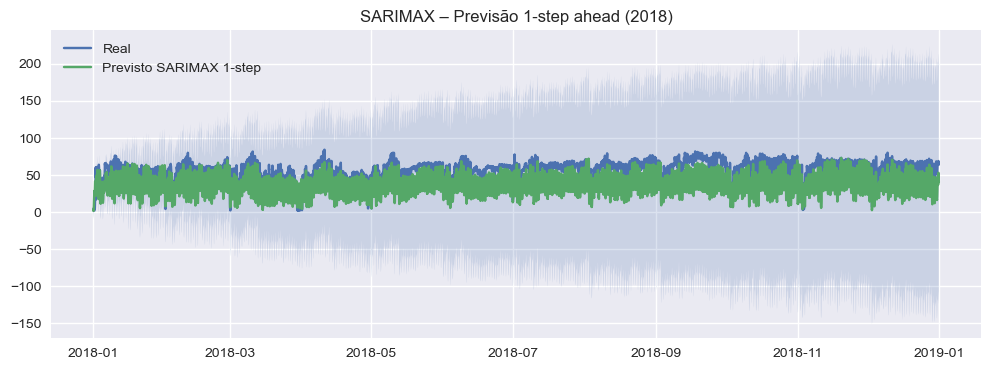

In [29]:
n_test = len(y_test)

forecast_sarimax = results_sarimax.get_forecast(
    steps=n_test,
    exog=exog_test
)

pred_sarimax = forecast_sarimax.predicted_mean
ci = forecast_sarimax.conf_int()

plt.figure(figsize=(12,4))
plt.plot(y_test, label='Real')
plt.plot(pred_sarimax, label='Previsto SARIMAX 1-step')
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.2)
plt.legend()
plt.title("SARIMAX – Previsão 1-step ahead (2018)")
plt.show()


In [30]:
pred_sarima = results_sarima.get_forecast(steps=n_test).predicted_mean


In [31]:
forecast_24 = results_sarimax.get_forecast(
    steps=24,
    exog=exog_test.iloc[:24]
)

pred_24 = forecast_24.predicted_mean
pred_24


2018-01-01 00:00:00     1.706831
2018-01-01 01:00:00     2.686733
2018-01-01 02:00:00     3.658928
2018-01-01 03:00:00     2.726414
2018-01-01 04:00:00     4.526539
2018-01-01 05:00:00     6.698389
2018-01-01 06:00:00    11.247906
2018-01-01 07:00:00    14.304336
2018-01-01 08:00:00    23.625464
2018-01-01 09:00:00    26.458814
2018-01-01 10:00:00    27.877650
2018-01-01 11:00:00    27.198459
2018-01-01 12:00:00    28.728274
2018-01-01 13:00:00    27.503051
2018-01-01 14:00:00    25.410979
2018-01-01 15:00:00    26.846519
2018-01-01 16:00:00    30.474374
2018-01-01 17:00:00    37.891339
2018-01-01 18:00:00    41.685609
2018-01-01 19:00:00    41.491553
2018-01-01 20:00:00    38.995936
2018-01-01 21:00:00    34.985761
2018-01-01 22:00:00    32.941184
2018-01-01 23:00:00    39.821840
Freq: h, Name: predicted_mean, dtype: float64

In [32]:
def compute_metrics(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # remover NaN
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    # evitar divisão por zero no MAPE
    non_zero = y_true != 0
    y_true = y_true[non_zero]
    y_pred = y_pred[non_zero]

    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return mae, rmse, mape


In [33]:
mae_sarima,  rmse_sarima,  mape_sarima  = compute_metrics(y_test, pred_sarima)
mae_sarimax, rmse_sarimax, mape_sarimax = compute_metrics(y_test, pred_sarimax)


In [34]:
results_stat = pd.DataFrame({
    "Model": ["SARIMA", "SARIMAX"],
    "MAE":   [mae_sarima, mae_sarimax],
    "RMSE":  [rmse_sarima, rmse_sarimax],
    "MAPE":  [mape_sarima, mape_sarimax]
})

results_stat


Model        MAE       RMSE       MAPE
0   SARIMA  11.580625  14.144302  31.374124
1  SARIMAX  19.301751  21.707958  37.357445

## Machine Learning models

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    BaggingRegressor
)
from sklearn.metrics import mean_absolute_error, mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Target variable
target = "price_day_ahead"


def make_sliding_window_dataset(df, target_col, window_size, horizon):
    """
    Creates a supervised learning dataset using a sliding window approach.

    Parameters:
    - df: DataFrame containing features and target (time-indexed)
    - target_col: name of the target variable
    - window_size: number of past time steps used as input
    - horizon: forecasting horizon (1-step or 24-step ahead)

    Returns:
    - X: numpy array of shape (n_samples, window_size + n_features)
    - y: pandas Series with DateTimeIndex aligned with forecast targets
    """
    # Remove missing values and ensure temporal ordering
    df = df.dropna().sort_index().copy()
    feature_cols = df.columns.drop(target_col)

    X_list = []
    y_list = []
    index_list = []

    values_target = df[target_col].values
    values_features = df[feature_cols].values
    idx = df.index.to_list()

    n = len(df)

    for i in range(window_size, n - horizon + 1):
        # Past prices: [t-window_size, ..., t-1]
        past_target = values_target[i - window_size:i]

        # Exogenous features at time t-1 (last step of the window)
        # Using t-1 avoids future data leakage
        current_features = values_features[i - 1]

        # Input vector = [past target window, current exogenous features]
        X_vec = np.concatenate([past_target, current_features])

        # Output = target value at time t + horizon - 1
        y_val = values_target[i + horizon - 1]

        X_list.append(X_vec)
        y_list.append(y_val)
        index_list.append(idx[i + horizon - 1])

    X = np.array(X_list)
    y = pd.Series(y_list, index=pd.to_datetime(index_list), name=target_col)

    return X, y

### Create datasets for each window size

In [36]:
window_sizes = [24, 48, 72]
horizons = [1, 24]
split_date = pd.Timestamp("2018-01-01")

ml_datasets = {}   # (window_size, horizon) -> (X_train, y_train, X_test, y_test)

for ws in window_sizes:
    for h in horizons:
        X_all, y_all = make_sliding_window_dataset(df_ml_scaled, target, ws, h)

        train_mask = y_all.index < split_date
        test_mask  = y_all.index >= split_date

        X_train_ws = X_all[train_mask]
        y_train_ws = y_all[train_mask]

        X_test_ws  = X_all[test_mask]
        y_test_ws = y_all[test_mask]

        ml_datasets[(ws, h)] = (X_train_ws, y_train_ws, X_test_ws, y_test_ws)

        print(f"Window {ws}h, horizon {h}:",
              f"train = {X_train_ws.shape}, test = {X_test_ws.shape}")

Window 24h, horizon 1: train = (26210, 53), test = (8759, 53)
Window 24h, horizon 24: train = (26187, 53), test = (8759, 53)
Window 48h, horizon 1: train = (26186, 77), test = (8759, 77)
Window 48h, horizon 24: train = (26163, 77), test = (8759, 77)
Window 72h, horizon 1: train = (26162, 101), test = (8759, 101)
Window 72h, horizon 24: train = (26139, 101), test = (8759, 101)


### Models and hyperparam grids

In [37]:
tscv = TimeSeriesSplit(n_splits=3)

model_configs = {
    "Linear Regression": {
        "estimator": LinearRegression(),
        "param_grid": {}  # sem tuning
    },
    "Decision Tree": {
        "estimator": DecisionTreeRegressor(random_state=42),
        "param_grid": {
            "max_depth": [5, None],
            "min_samples_split": [2, 10]
        }
    },
    "KNN Regressor": {
        "estimator": KNeighborsRegressor(),
        "param_grid": {
            "n_neighbors": [3, 5, 10],
            "weights": ["uniform", "distance"]
        }
    },
    "SVR": {
        "estimator": SVR(),
        "param_grid": {
            "C": [1, 10],
            "epsilon": [0.1, 0.2],
            "kernel": ["rbf"]
        }
    },
    "Bagging Regressor": {
        "estimator": BaggingRegressor(random_state=42),
        "param_grid": {
            "n_estimators": [50, 100],
            "max_samples": [0.5, 1.0]
        }
    },
    "Gradient Boosting": {
        "estimator": GradientBoostingRegressor(random_state=42),
        "param_grid": {
            "n_estimators": [100, 200],
            "learning_rate": [0.05, 0.1],
            "max_depth": [2, 3]
        }
    },
    "Random Forest": {
        "estimator": RandomForestRegressor(random_state=42, n_jobs=-1),
        "param_grid": {
            "n_estimators": [200],
            "max_depth": [5, 10, None],
            "min_samples_split": [2, 10]
        }
    },
    "XGBoost": {
        "estimator": XGBRegressor(
            random_state=42,
            objective="reg:squarederror",
            n_jobs=-1
        ),
        "param_grid": {
            "n_estimators": [200],
            "max_depth": [3, 5],
            "learning_rate": [0.05, 0.1]
        }
    },
    "LightGBM": {
        "estimator": LGBMRegressor(
            random_state=42
        ),
        "param_grid": {
            "n_estimators": [200],
            "num_leaves": [31, 63],
            "learning_rate": [0.05, 0.1]
        }
    }
}

### Traning and saving models/predictions

In [38]:
def train_model_with_tscv(X_train, y_train, estimator, param_grid, scoring="neg_mean_absolute_error"):
    """
    Trains a model using TimeSeriesSplit and GridSearchCV.
    If param_grid is empty, the model is fitted directly without hyperparameter tuning.
    """
    if not param_grid:
        estimator.fit(X_train, y_train)
        return estimator, None

    gsearch = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=tscv,
        scoring=scoring,
        n_jobs=-1
    )
    gsearch.fit(X_train, y_train)
    return gsearch.best_estimator_, gsearch.best_params_


def evaluate_predictions(y_true, y_pred):
    """
    Computes evaluation metrics: MAE, RMSE, and MAPE.
    """
    y_true, y_pred = y_true.align(y_pred, join="inner")

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape
    }

# Containers for trained models, predictions, and evaluation results
ml_models = {}        # (window_size, horizon) -> {model_name: fitted_model}
ml_predictions = {}   # (window_size, horizon) -> {model_name: pd.Series predictions}
ml_scores = {}        # (window_size, horizon) -> {model_name: metrics_dict}
ml_best_params = {}   # (window_size, horizon) -> {model_name: best_params}


### Training all ML models

In [39]:
for ws in window_sizes:
    for h in horizons:
        print(f"\n==============================")
        print(f"Training models - window={ws}h, horizon={h}")
        print(f"==============================")

        X_train_ws, y_train_ws, X_test_ws, y_test_ws = ml_datasets[(ws, h)]

        ml_models[(ws, h)] = {}
        ml_predictions[(ws, h)] = {}
        ml_scores[(ws, h)] = {}
        ml_best_params[(ws, h)] = {}

        for model_name, cfg in model_configs.items():
            print(f"\n>> {model_name} (ws={ws}, h={h})")
            est = cfg["estimator"]
            param_grid = cfg["param_grid"]

            try:
                # ------------------------------------------------
                # CASE 1: window_size = 24 → full GridSearch
                # ------------------------------------------------
                if ws == 24 and param_grid:
                    best_model, best_params = train_model_with_tscv(
                        X_train_ws, y_train_ws, est, param_grid
                    )
                    ml_best_params[(ws, h)][model_name] = best_params

                # ------------------------------------------------
                # CASE 2: window_size != 24 → reuse best params
                # ------------------------------------------------
                elif (
                    ws != 24
                    and model_name in ml_best_params[(24, h)]
                    and ml_best_params[(24, h)][model_name] is not None
                ):
                    est.set_params(**ml_best_params[(24, h)][model_name])
                    est.fit(X_train_ws, y_train_ws)
                    best_model = est
                    ml_best_params[(ws, h)][model_name] = ml_best_params[(24, h)][model_name]

                # ------------------------------------------------
                # CASE 3: models without param grid
                # ------------------------------------------------
                else:
                    est.fit(X_train_ws, y_train_ws)
                    best_model = est
                    ml_best_params[(ws, h)][model_name] = None

                # save model
                ml_models[(ws, h)][model_name] = best_model

                # predictions on test set
                y_pred = best_model.predict(X_test_ws)
                y_pred_series = pd.Series(
                    y_pred, index=y_test_ws.index, name=f"{model_name}_pred"
                )
                ml_predictions[(ws, h)][model_name] = y_pred_series

                # metrics
                ml_scores[(ws, h)][model_name] = evaluate_predictions(
                    y_test_ws, y_pred_series
                )

                print("   Done!")

            except Exception as e:
                print(f"   ⚠ Error training {model_name}: {e}")


Training models - window=24h, horizon=1

>> Linear Regression (ws=24, h=1)
   Done!

>> Decision Tree (ws=24, h=1)
   Done!

>> KNN Regressor (ws=24, h=1)
   Done!

>> SVR (ws=24, h=1)
   Done!

>> Bagging Regressor (ws=24, h=1)
   Done!

>> Gradient Boosting (ws=24, h=1)
   Done!

>> Random Forest (ws=24, h=1)
   Done!

>> XGBoost (ws=24, h=1)
   Done!

>> LightGBM (ws=24, h=1)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11952
[LightGBM] [Info] Number of data points in the train set: 26210, number of used features: 53
[LightGBM] [Info] Start training from score 47.465847


c:\Users\hugo7\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


   Done!

Training models - window=24h, horizon=24

>> Linear Regression (ws=24, h=24)
   Done!

>> Decision Tree (ws=24, h=24)
   Done!

>> KNN Regressor (ws=24, h=24)
   Done!

>> SVR (ws=24, h=24)
   Done!

>> Bagging Regressor (ws=24, h=24)
   Done!

>> Gradient Boosting (ws=24, h=24)
   Done!

>> Random Forest (ws=24, h=24)
   Done!

>> XGBoost (ws=24, h=24)
   Done!

>> LightGBM (ws=24, h=24)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11952
[LightGBM] [Info] Number of data points in the train set: 26187, number of used features: 53
[LightGBM] [Info] Start training from score 47.475389


c:\Users\hugo7\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


   Done!

Training models - window=48h, horizon=1

>> Linear Regression (ws=48, h=1)
   Done!

>> Decision Tree (ws=48, h=1)
   Done!

>> KNN Regressor (ws=48, h=1)
   Done!

>> SVR (ws=48, h=1)
   Done!

>> Bagging Regressor (ws=48, h=1)
   Done!

>> Gradient Boosting (ws=48, h=1)
   Done!

>> Random Forest (ws=48, h=1)
   Done!

>> XGBoost (ws=48, h=1)
   Done!

>> LightGBM (ws=48, h=1)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18072
[LightGBM] [Info] Number of data points in the train set: 26186, number of used features: 77
[LightGBM] [Info] Start training from score 47.474910


c:\Users\hugo7\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


   Done!

Training models - window=48h, horizon=24

>> Linear Regression (ws=48, h=24)
   Done!

>> Decision Tree (ws=48, h=24)
   Done!

>> KNN Regressor (ws=48, h=24)
   Done!

>> SVR (ws=48, h=24)
   Done!

>> Bagging Regressor (ws=48, h=24)
   Done!

>> Gradient Boosting (ws=48, h=24)
   Done!

>> Random Forest (ws=48, h=24)
   Done!

>> XGBoost (ws=48, h=24)
   Done!

>> LightGBM (ws=48, h=24)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18072
[LightGBM] [Info] Number of data points in the train set: 26163, number of used features: 77
[LightGBM] [Info] Start training from score 47.467685


c:\Users\hugo7\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


   Done!

Training models - window=72h, horizon=1

>> Linear Regression (ws=72, h=1)
   Done!

>> Decision Tree (ws=72, h=1)
   Done!

>> KNN Regressor (ws=72, h=1)
   Done!

>> SVR (ws=72, h=1)
   Done!

>> Bagging Regressor (ws=72, h=1)
   Done!

>> Gradient Boosting (ws=72, h=1)
   Done!

>> Random Forest (ws=72, h=1)
   Done!

>> XGBoost (ws=72, h=1)
   Done!

>> LightGBM (ws=72, h=1)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24193
[LightGBM] [Info] Number of data points in the train set: 26162, number of used features: 101
[LightGBM] [Info] Start training from score 47.467221


c:\Users\hugo7\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


   Done!

Training models - window=72h, horizon=24

>> Linear Regression (ws=72, h=24)
   Done!

>> Decision Tree (ws=72, h=24)
   Done!

>> KNN Regressor (ws=72, h=24)
   Done!

>> SVR (ws=72, h=24)
   Done!

>> Bagging Regressor (ws=72, h=24)
   Done!

>> Gradient Boosting (ws=72, h=24)
   Done!

>> Random Forest (ws=72, h=24)
   Done!

>> XGBoost (ws=72, h=24)
   Done!

>> LightGBM (ws=72, h=24)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24192
[LightGBM] [Info] Number of data points in the train set: 26139, number of used features: 101
[LightGBM] [Info] Start training from score 47.456970
   Done!


c:\Users\hugo7\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


### Training Scores

While both 1-step and 24-step ahead forecasting horizons were evaluated, the analysis focuses primarily on the 1-step ahead case, where models achieve higher accuracy and clearer performance differences.

The 24-step ahead results are presented to highlight the increased uncertainty and difficulty associated with longer forecasting horizons.

In [40]:
def show_ml_scores_table(window_size, horizon):
    print("\n" + "=" * 70)
    print(f"ML RESULTS — Window Size = {window_size} hours | Horizon = {horizon}-step ahead")
    print("=" * 70)

    scores_dict = ml_scores.get((window_size, horizon), {})
    if not scores_dict:
        print("No scores stored for this configuration.")
        return

    df_scores = pd.DataFrame(scores_dict).T
    display(df_scores.sort_values("MAE"))

show_ml_scores_table(24, 1)
show_ml_scores_table(24, 24)
show_ml_scores_table(72, 1)


ML RESULTS — Window Size = 24 hours | Horizon = 1-step ahead


MAE      RMSE  MAPE (%)
SVR                1.757950  2.986804  4.248352
Random Forest      1.933689  3.128960  4.493629
Bagging Regressor  1.970184  3.096368  4.531832
XGBoost            1.978314  3.066897  4.764286
Linear Regression  2.020586  3.110913  4.791336
Gradient Boosting  2.062613  3.170297  5.447669
LightGBM           2.143747  3.170585  4.937212
Decision Tree      2.591119  3.724306  5.836022
KNN Regressor      3.412684  4.698562  8.511841


ML RESULTS — Window Size = 24 hours | Horizon = 24-step ahead


MAE       RMSE   MAPE (%)
SVR                7.144818   9.667560  22.814586
Random Forest      7.790600  10.119790  24.510547
Decision Tree      8.242362  10.670723  25.372256
Gradient Boosting  8.325020  10.330317  24.463001
KNN Regressor      8.705148  11.377587  25.879564
Linear Regression  9.296040  11.178171  25.221755
XGBoost            9.340800  11.374982  24.995106
Bagging Regressor  9.656730  11.904468  26.364570
LightGBM           9.883303  11.956347  26.138004


ML RESULTS — Window Size = 72 hours | Horizon = 1-step ahead


MAE      RMSE   MAPE (%)
SVR                1.830010  3.021237   4.508005
Bagging Regressor  1.935837  3.073147   4.515691
Random Forest      1.940105  3.129359   4.561776
XGBoost            1.960928  3.053222   4.717245
Linear Regression  2.012191  3.085996   4.805496
LightGBM           2.095033  3.121642   4.863133
Gradient Boosting  2.133498  3.246388   5.619014
Decision Tree      2.591326  3.724495   5.835966
KNN Regressor      4.799195  6.446758  13.549323

### Machine Learning Plots


PLOTS — Window Size = 24 hours | Horizon = 1-step ahead


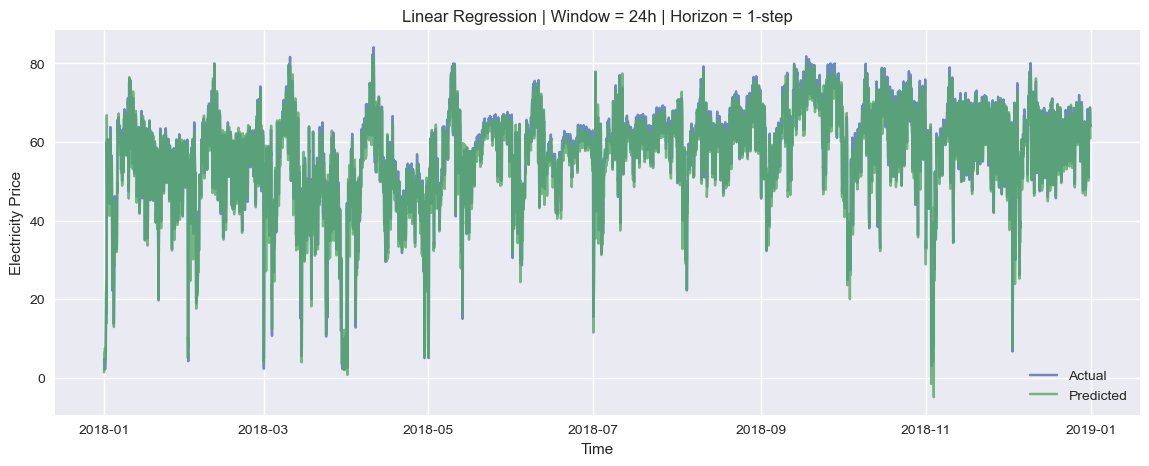

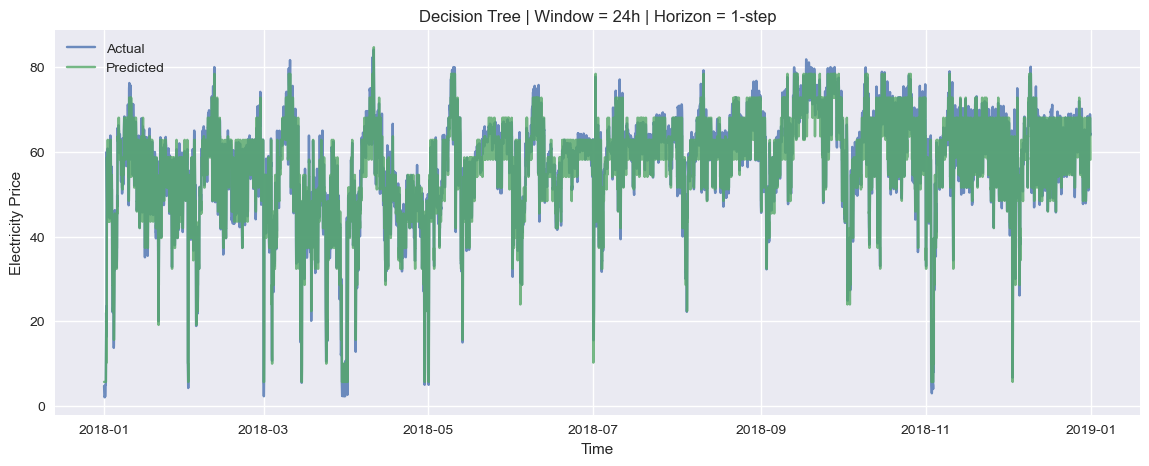

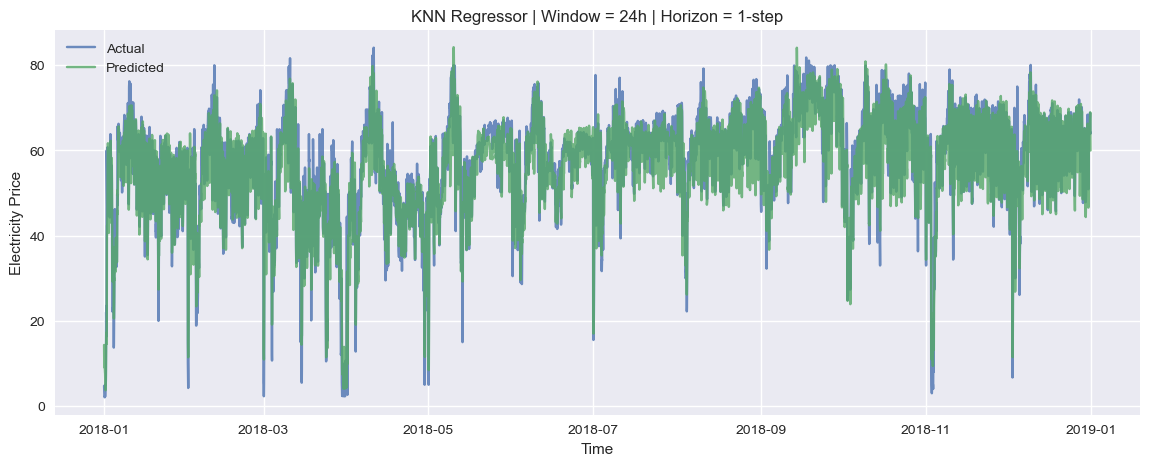

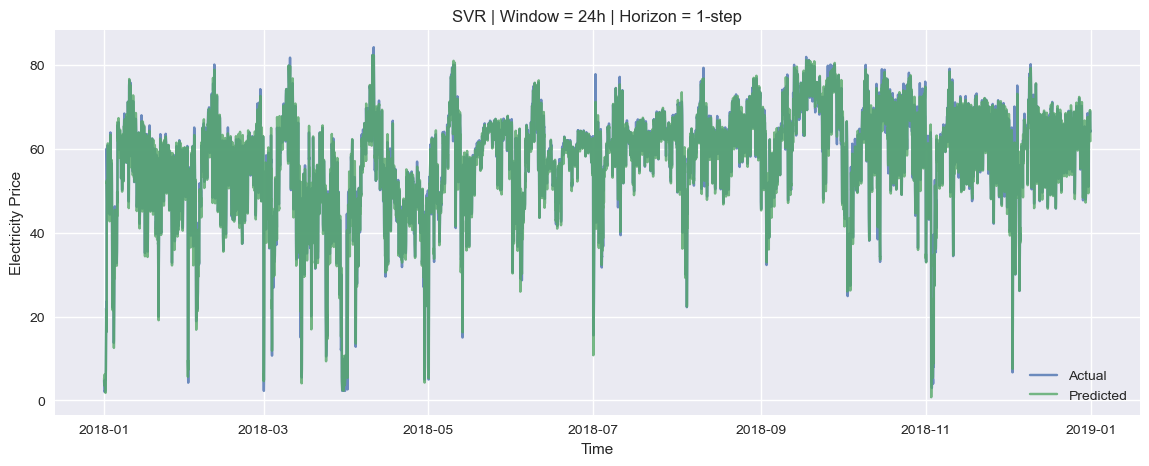

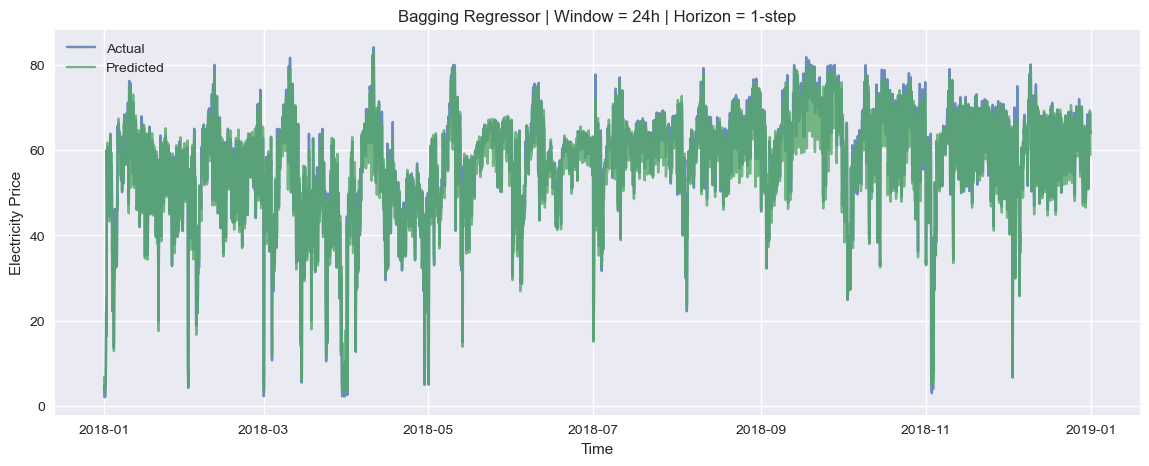

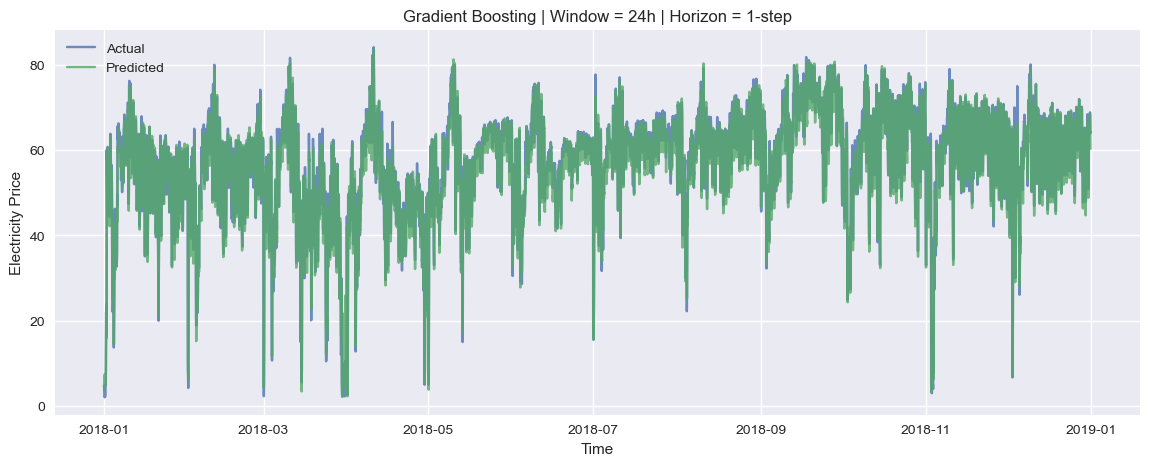

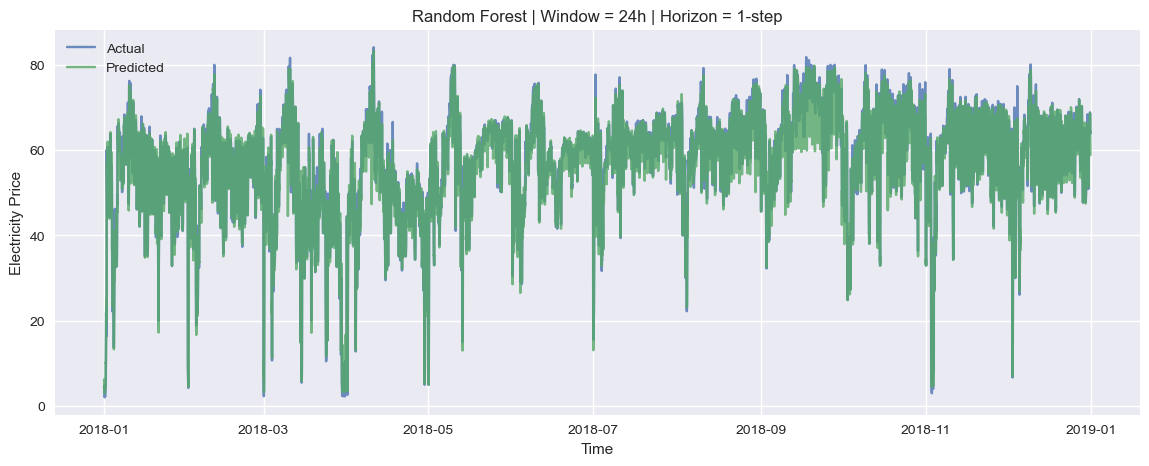

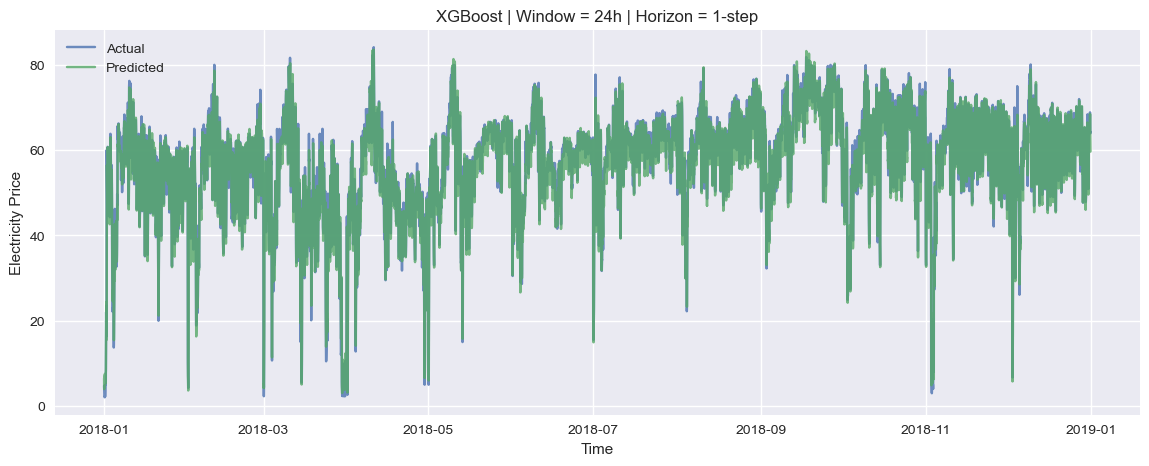

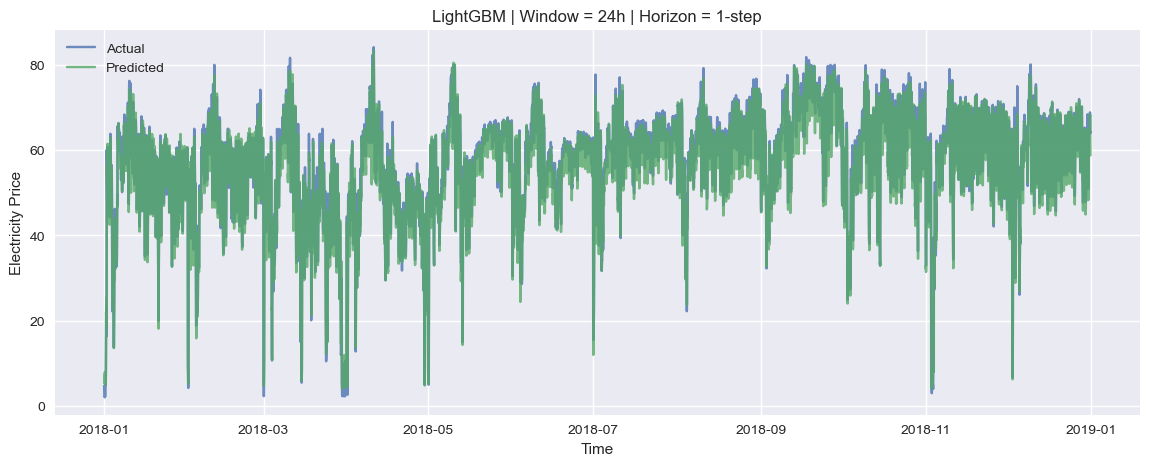


PLOTS — Window Size = 24 hours | Horizon = 24-step ahead


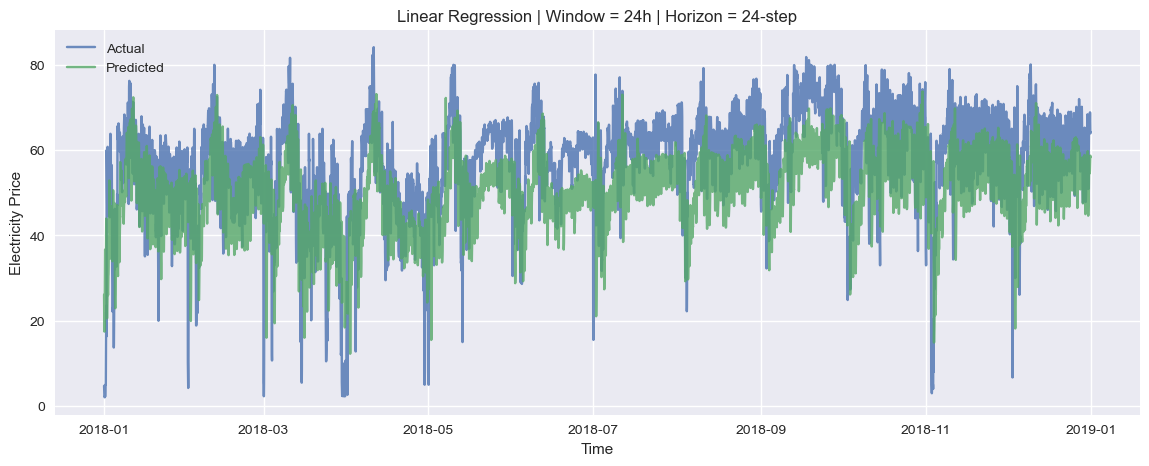

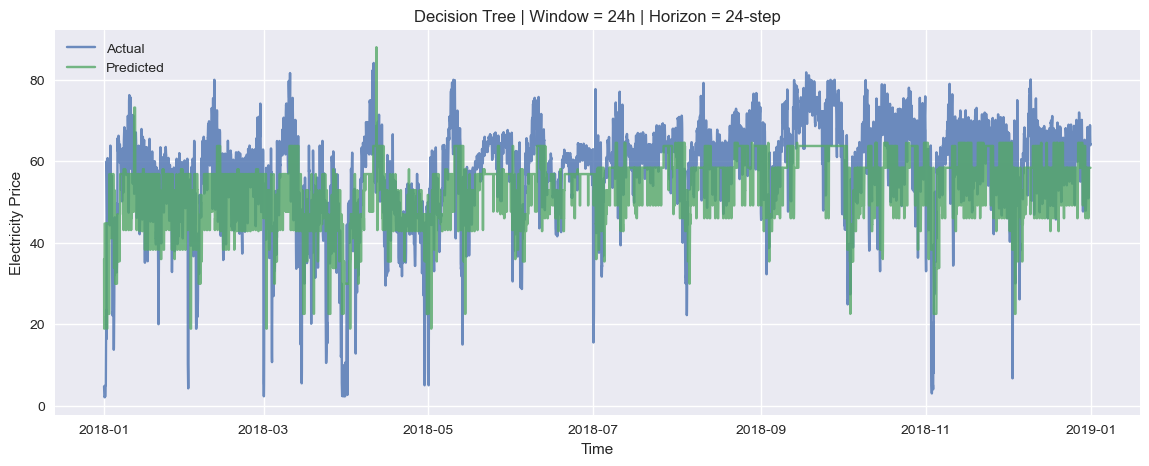

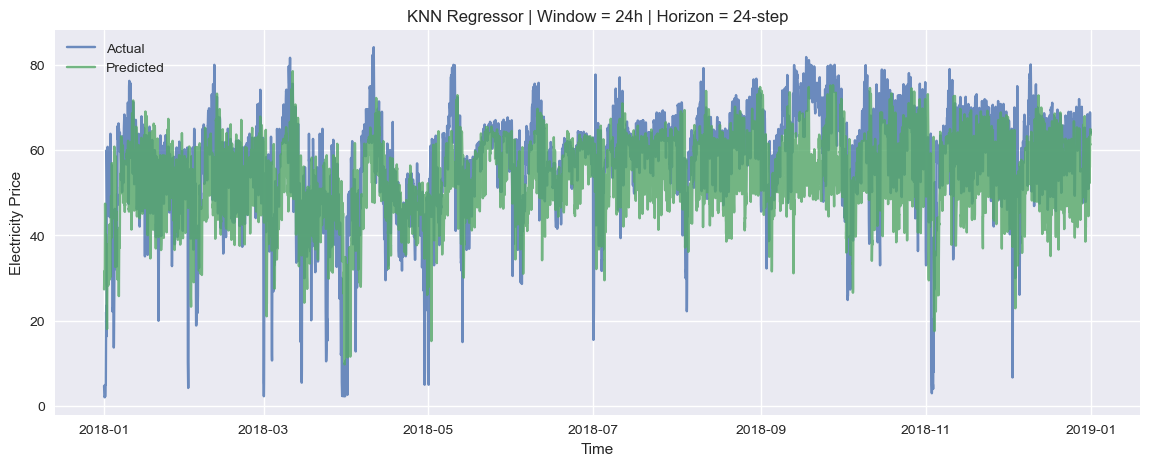

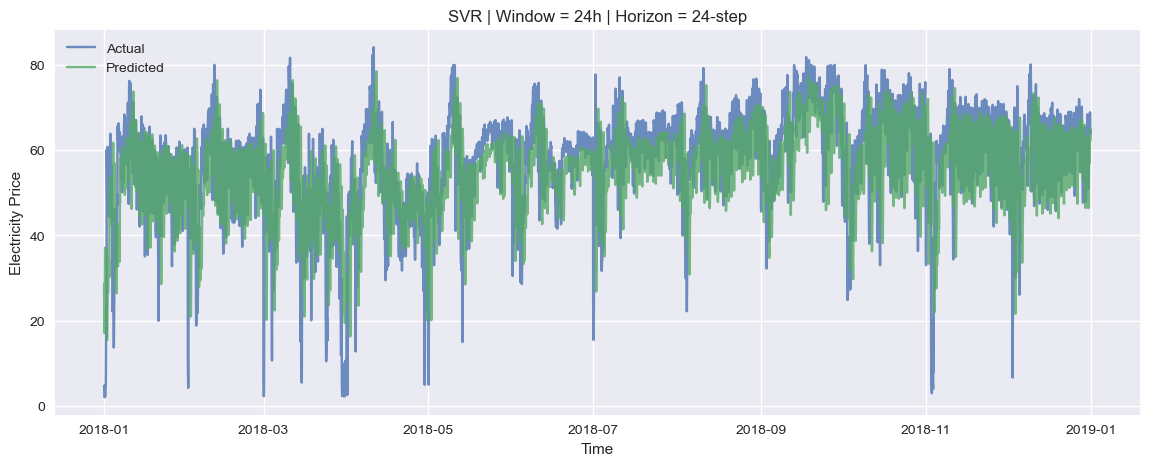

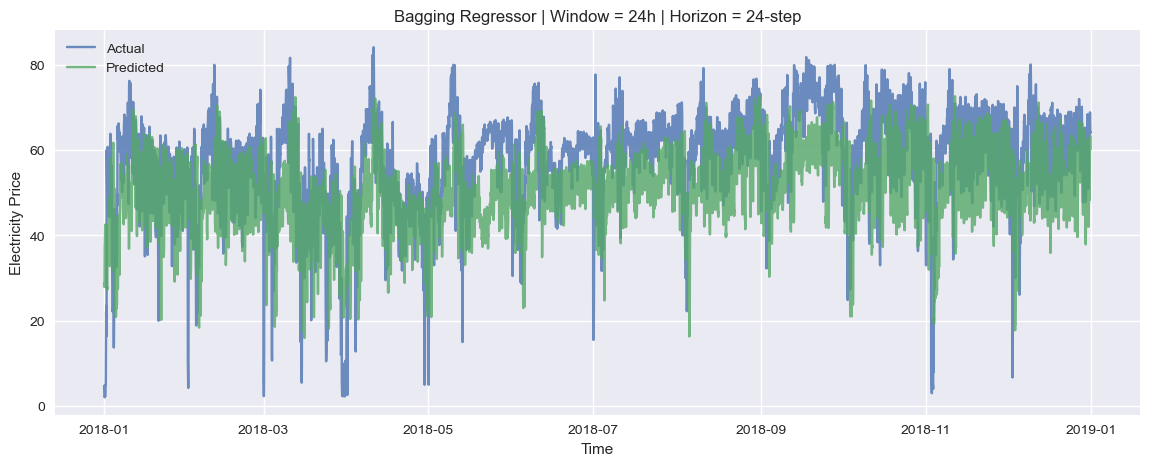

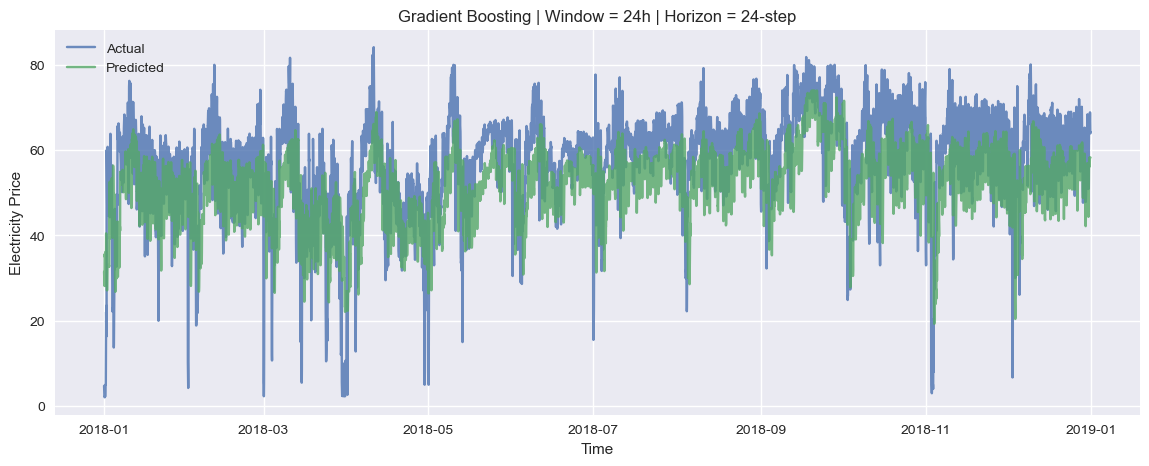

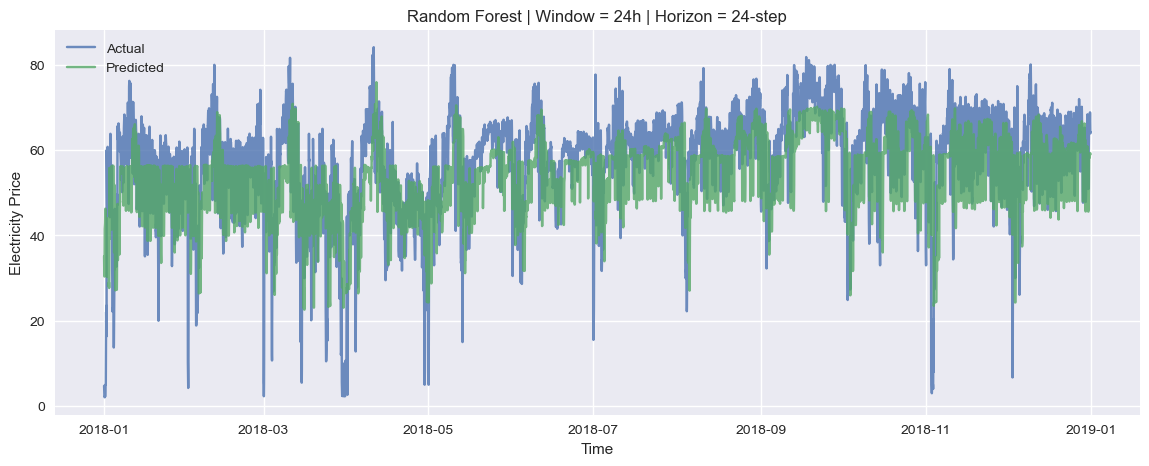

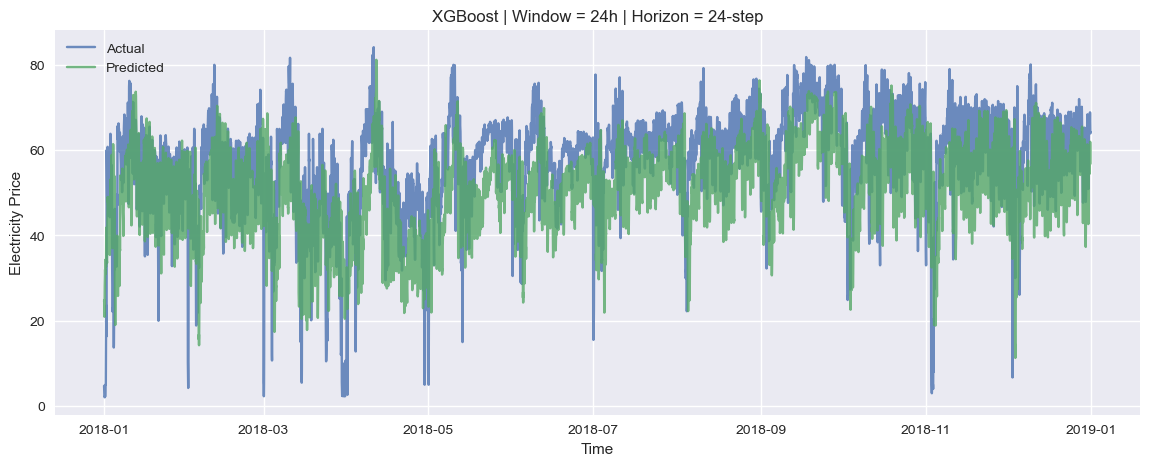

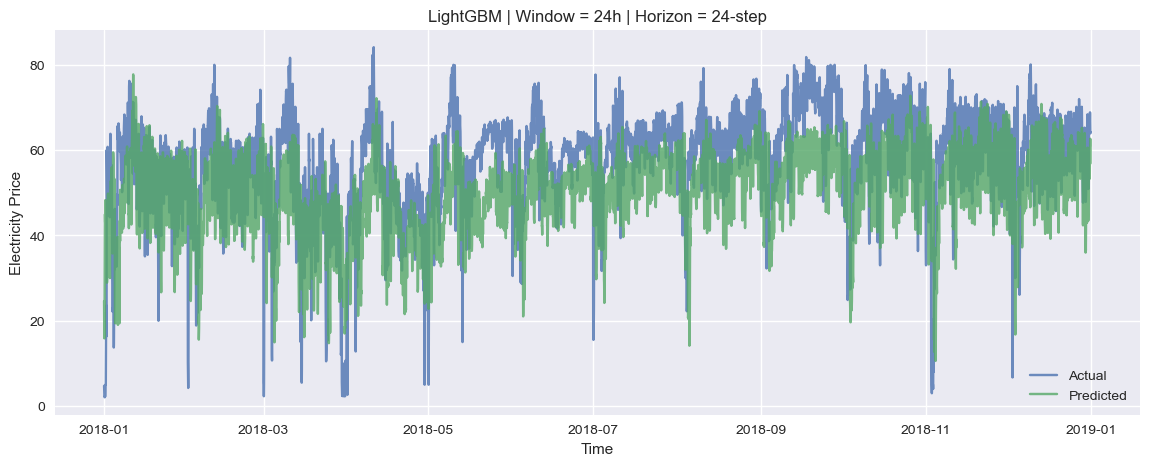


PLOTS — Window Size = 72 hours | Horizon = 1-step ahead


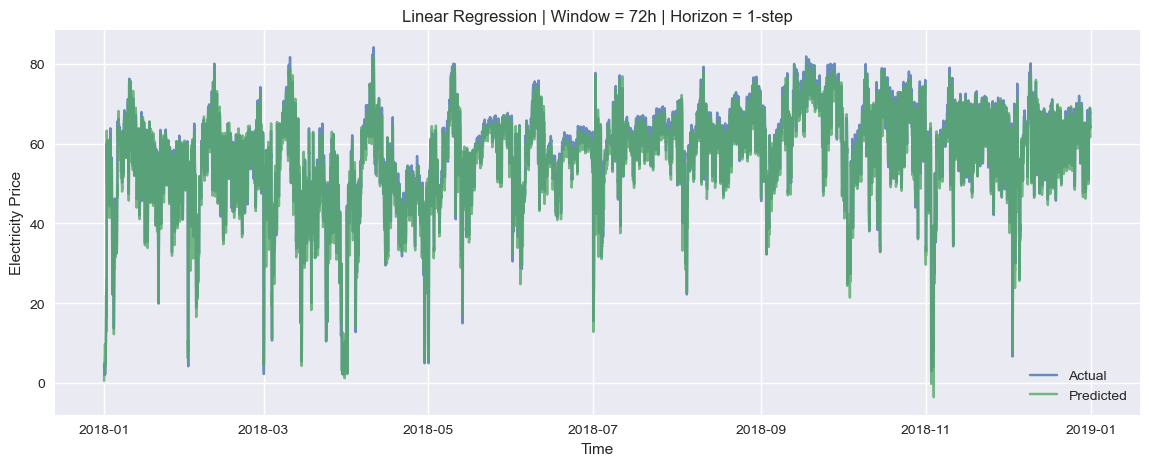

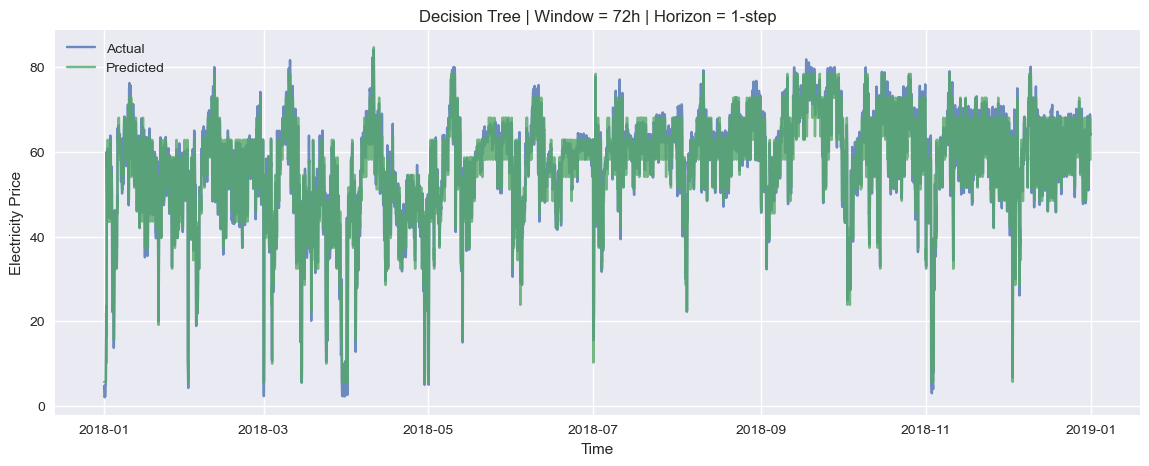

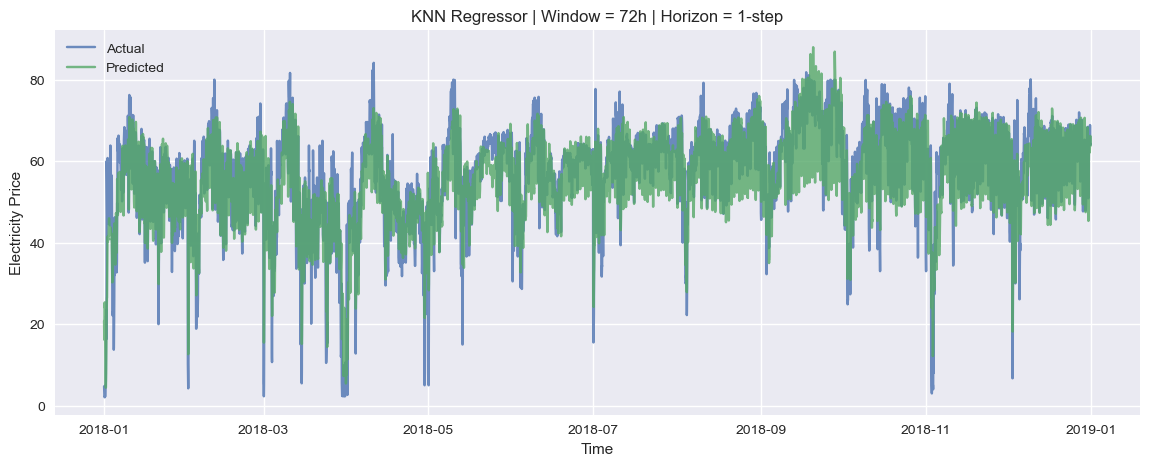

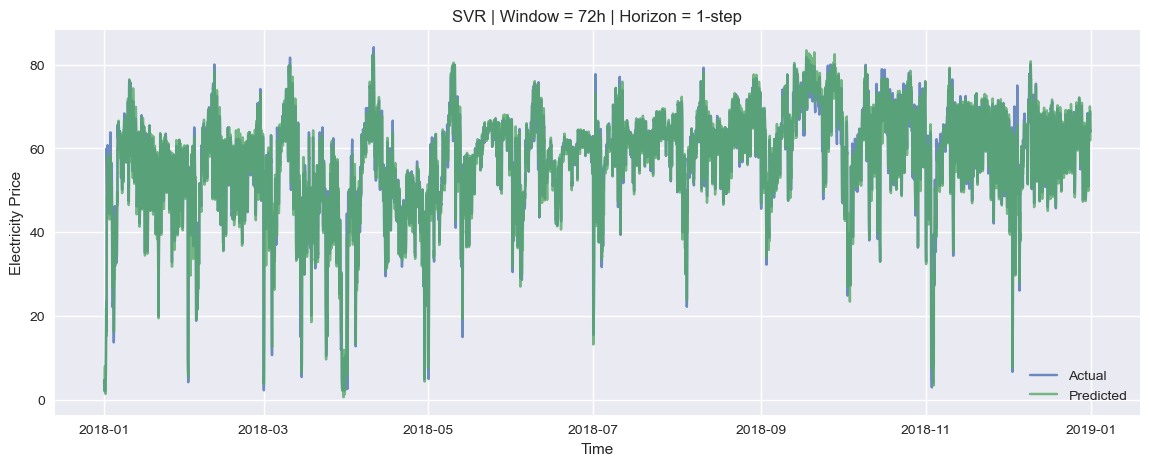

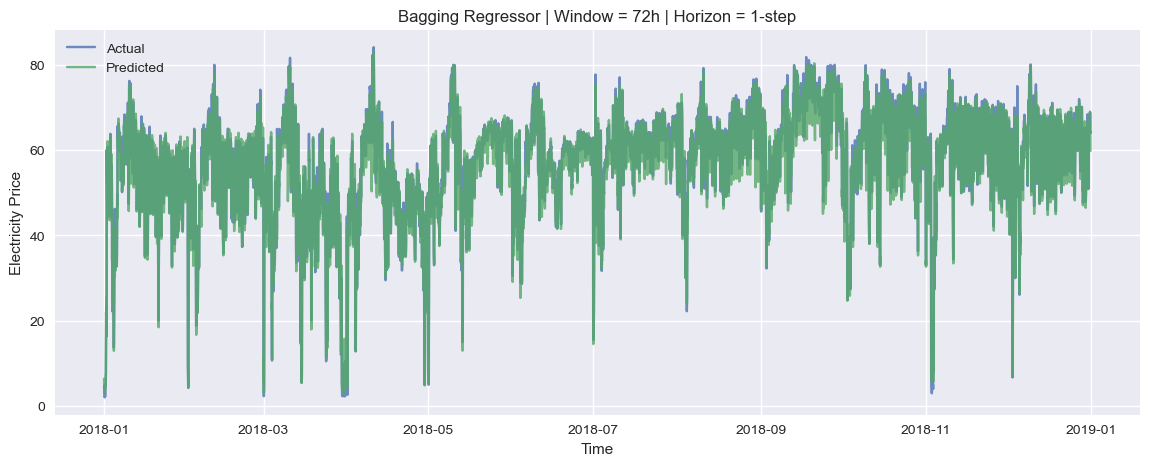

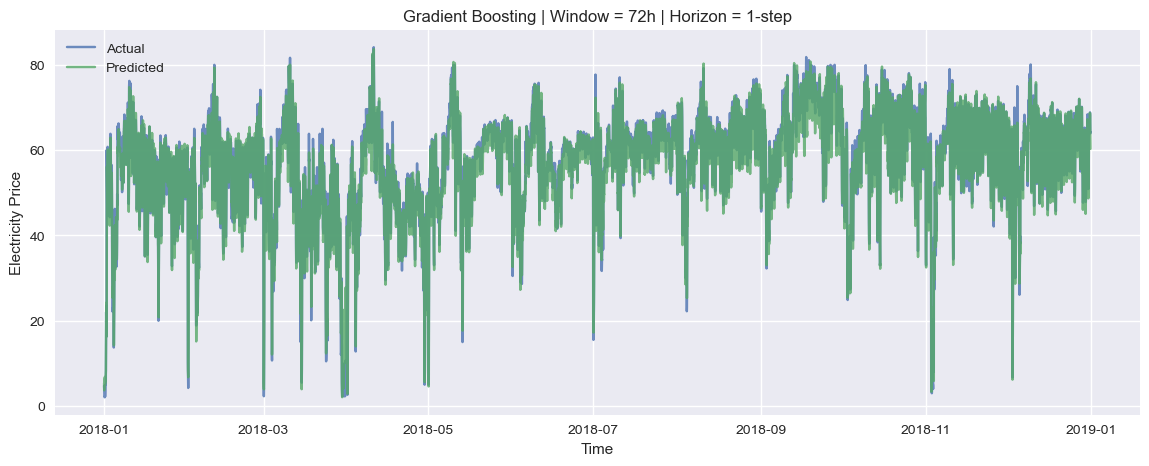

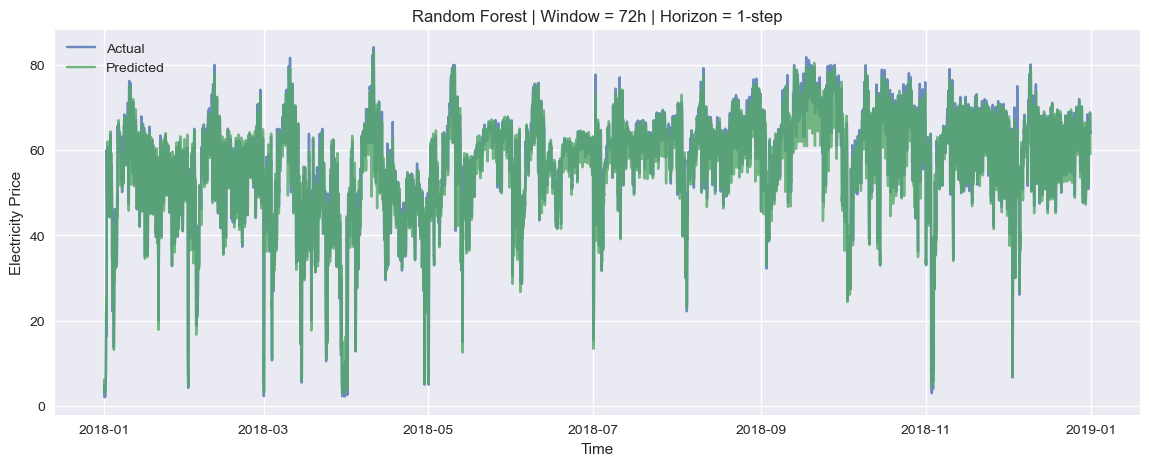

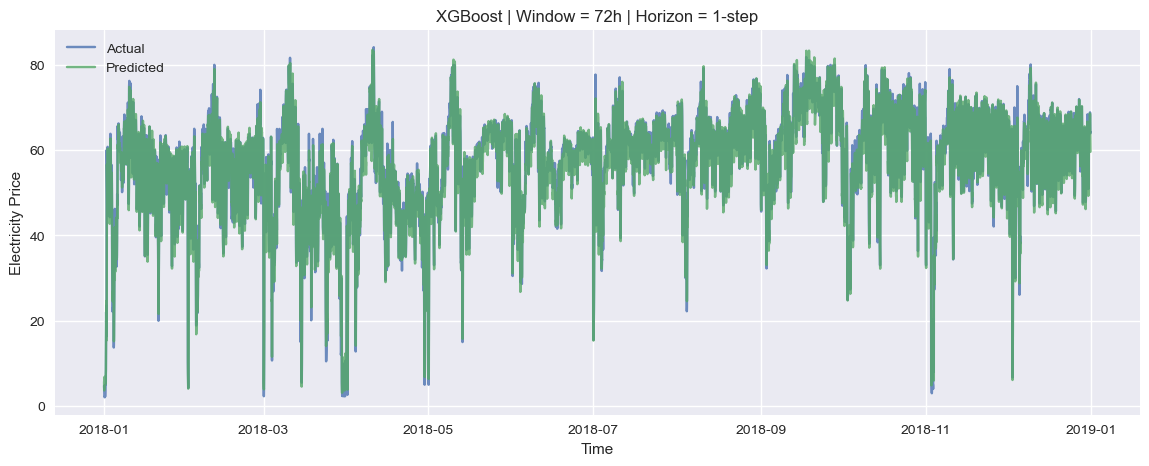

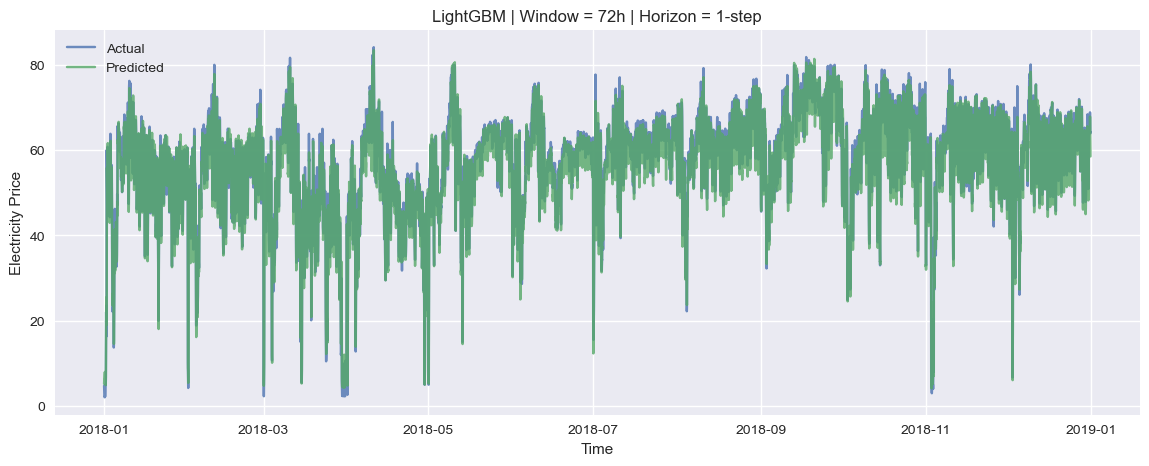

In [41]:
def plot_all_models(window_size, horizon):
    """
    Generates one plot (Actual vs Predicted) for each trained model
    with a clear section header indicating window size and horizon.
    """
    print("\n" + "=" * 70)
    print(f"PLOTS — Window Size = {window_size} hours | Horizon = {horizon}-step ahead")
    print("=" * 70)

    _, _, _, y_test_ws = ml_datasets[(window_size, horizon)]

    for model_name, preds in ml_predictions[(window_size, horizon)].items():
        y_true, y_pred = y_test_ws.align(preds, join="inner")

        plt.figure(figsize=(14,5))
        plt.plot(y_true.index, y_true, label="Actual", alpha=0.8)
        plt.plot(y_pred.index, y_pred, label="Predicted", alpha=0.8)
        plt.title(
            f"{model_name} | Window = {window_size}h | Horizon = {horizon}-step",
            fontsize=12
        )
        plt.xlabel("Time")
        plt.ylabel("Electricity Price")
        plt.legend()
        plt.show()

plot_all_models(24, 1)
plot_all_models(24, 24)
plot_all_models(72, 1)

## Deep Learning

Criar Sliding Window para Deep Learning

In [42]:
def create_windows(data, target_col, window_size=24):
    X, y = [], []
    values = data.values
    target_idx = data.columns.get_loc(target_col)
    
    for i in range(window_size, len(values)):
        X.append(values[i-window_size:i])          # janela de features
        y.append(values[i, target_idx])            # target seguinte

    return np.array(X), np.array(y)


In [43]:
window_size = 24  # previsão 1-step ahead baseado em 24h

X_train, y_train = create_windows(train_ml, target, window_size)
X_test,  y_test  = create_windows(test_ml,  target, window_size)

X_train.shape, X_test.shape


((26210, 24, 30), (8735, 24, 30))

Modelo LSTM

In [44]:

model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.summary()


c:\Users\hugo7\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        24,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,769 (143.63 KB)

 Trainable params: 36,769 (143.63 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
es = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

Epoch 1/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 1094.9152 - val_loss: 838.0927
Epoch 2/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 311.9499 - val_loss: 289.1521
Epoch 3/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 106.1668 - val_loss: 121.1365
Epoch 4/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 48.8891 - val_loss: 61.5743
Epoch 5/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 28.5051 - val_loss: 35.3805
Epoch 6/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 19.9353 - val_loss: 22.0537
Epoch 7/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 15.8287 - val_loss: 15.4322
Epoch 8/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 13.5221 - val_loss: 12.1320
Epoch 9/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 11.9545 - val_loss: 9.7938
Epoch 10/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 10.8641 - val_loss: 8.8627
Epoch 11/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 10.1140 - val_loss: 8.7386
Epoch 12/50
738/738 ━━━━━━

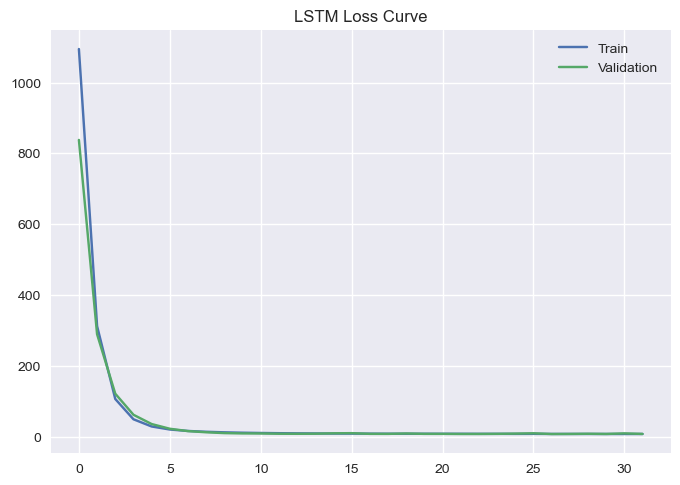

In [46]:

plt.plot(history_lstm.history['loss'], label='Train')
plt.plot(history_lstm.history['val_loss'], label='Validation')
plt.title("LSTM Loss Curve")
plt.legend()
plt.show()

In [47]:
pred_lstm = model_lstm.predict(X_test).flatten()

273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Modelo GRU

In [48]:
model_gru = Sequential([
    tf.keras.layers.GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.GRU(32),
    Dense(1)
])

model_gru.compile(optimizer='adam', loss='mse')
model_gru.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 24, 64)         │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,873 (108.88 KB)

 Trainable params: 27,873 (108.88 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
history_gru = model_gru.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[es],
    verbose=1
)


Epoch 1/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 1084.1964 - val_loss: 851.1707
Epoch 2/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 319.2327 - val_loss: 296.1885
Epoch 3/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 108.6398 - val_loss: 123.3840
Epoch 4/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 49.4748 - val_loss: 62.1919
Epoch 5/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 28.5585 - val_loss: 35.3505


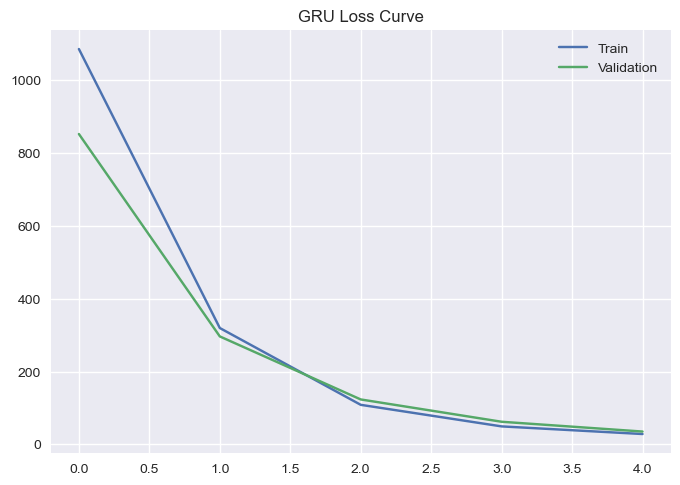

In [50]:
plt.plot(history_gru.history['loss'], label='Train')
plt.plot(history_gru.history['val_loss'], label='Validation')
plt.title("GRU Loss Curve")
plt.legend()
plt.show()


In [51]:
pred_gru = model_gru.predict(X_test).flatten()


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


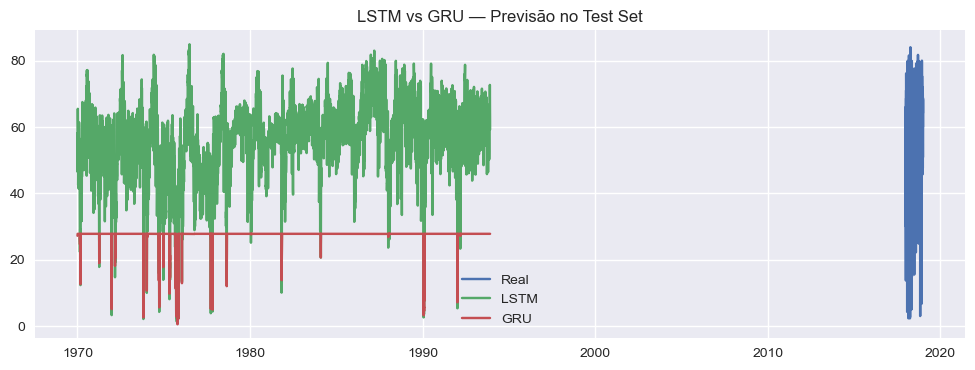

In [52]:

y_test_series = test_ml[target].iloc[window_size:]

plt.figure(figsize=(12,4))
plt.plot(y_test_series, label='Real')
plt.plot(pred_lstm, label='LSTM')
plt.plot(pred_gru, label='GRU')
plt.legend()
plt.title("LSTM vs GRU — Previsão no Test Set")
plt.show()


In [53]:
print(len(y_test))
print(len(pred_lstm))
print("min y_test:", np.min(y_test))
print("max y_test:", np.max(y_test))
print("NaN em pred_lstm:", np.isnan(pred_lstm).sum())
print("Inf em pred_lstm:", np.isinf(pred_lstm).sum())

print("NaN em pred_gru:", np.isnan(pred_gru).sum())
print("Inf em pred_gru:", np.isinf(pred_gru).sum())
mae_lstm, rmse_lstm, mape_lstm = compute_metrics(y_test, pred_lstm)
mae_gru,  rmse_gru,  mape_gru  = compute_metrics(y_test, pred_gru)


8735
8735
min y_test: 2.3
max y_test: 84.13
NaN em pred_lstm: 0
Inf em pred_lstm: 0
NaN em pred_gru: 0
Inf em pred_gru: 0


In [54]:
results_dl = pd.DataFrame({
    "Model": ["LSTM", "GRU"],
    "MAE":   [mae_lstm, mae_gru],
    "RMSE":  [rmse_lstm, rmse_gru],
    "MAPE":  [mape_lstm, mape_gru]
})

results_dl

Model        MAE       RMSE       MAPE
0  LSTM   2.044885   3.035623   4.252400
1   GRU  30.058082  32.077367  50.187336

### Deep Learning Results Summary

In [55]:
print("\n" + "="*70)
print("DEEP LEARNING RESULTS — 1-step ahead forecasting")
print("="*70)
display(results_dl.sort_values("MAE"))


DEEP LEARNING RESULTS — 1-step ahead forecasting


Model        MAE       RMSE       MAPE
0  LSTM   2.044885   3.035623   4.252400
1   GRU  30.058082  32.077367  50.187336

# 4. Model Evaluation and Comparison

## 4.1 Statistical Models Evaluation

In [56]:
print("\n" + "="*70)
print("STATISTICAL MODELS — Performance Metrics (2018 test set)")
print("="*70)
display(results_stat.sort_values("MAE"))


STATISTICAL MODELS — Performance Metrics (2018 test set)


Model        MAE       RMSE       MAPE
0   SARIMA  11.580625  14.144302  31.374124
1  SARIMAX  19.301751  21.707958  37.357445

## 4.2 Machine Learning Models Evaluation

In [57]:
# Mostrar resultados ML (window=24, horizon=1)
ws, h = 24, 1
ml_results_df = pd.DataFrame(ml_scores[(ws, h)]).T

print("\n" + "="*70)
print("MACHINE LEARNING MODELS — Performance Metrics (2018 test set)")
print(f"Configuration: Window Size = {ws}h, Horizon = {h}-step ahead")
print("="*70)
display(ml_results_df.sort_values("MAE"))


MACHINE LEARNING MODELS — Performance Metrics (2018 test set)
Configuration: Window Size = 24h, Horizon = 1-step ahead


MAE      RMSE  MAPE (%)
SVR                1.757950  2.986804  4.248352
Random Forest      1.933689  3.128960  4.493629
Bagging Regressor  1.970184  3.096368  4.531832
XGBoost            1.978314  3.066897  4.764286
Linear Regression  2.020586  3.110913  4.791336
Gradient Boosting  2.062613  3.170297  5.447669
LightGBM           2.143747  3.170585  4.937212
Decision Tree      2.591119  3.724306  5.836022
KNN Regressor      3.412684  4.698562  8.511841

## 4.3 Deep Learning Models Evaluation

In [58]:
print("\n" + "="*70)
print("DEEP LEARNING MODELS — Performance Metrics (2018 test set)")
print("="*70)
display(results_dl.sort_values("MAE"))


DEEP LEARNING MODELS — Performance Metrics (2018 test set)


Model        MAE       RMSE       MAPE
0  LSTM   2.044885   3.035623   4.252400
1   GRU  30.058082  32.077367  50.187336

## 4.4 Baseline Model: Seasonal Naïve

The **Seasonal Naïve** model serves as a simple but effective baseline for electricity price forecasting.  
It predicts the value from exactly 24 hours ago (one day seasonal lag).

In [65]:
# Seasonal Naïve: previsão = valor de 24 horas atrás
# Baseline: prever o valor de 24h atrás

# Usar test_stat diretamente porque y_test foi redefinido como numpy array no Deep Learning
y_test_stat = test_stat['price_day_ahead']
seasonal_naive_pred = y_test_stat.shift(24).dropna()
y_test_baseline = y_test_stat[seasonal_naive_pred.index]

mae_naive, rmse_naive, mape_naive = compute_metrics(
    y_test_baseline, 
    seasonal_naive_pred
)

baseline_results = pd.DataFrame({
    "Model": ["Seasonal Naïve"],
    "MAE": [mae_naive],
    "RMSE": [rmse_naive],
    "MAPE (%)": [mape_naive]
})

print("\n" + "="*70)
print("BASELINE MODEL — Performance Metrics (2018 test set)")
print("="*70)
display(baseline_results)


BASELINE MODEL — Performance Metrics (2018 test set)


Model       MAE       RMSE   MAPE (%)
0  Seasonal Naïve  7.010173  10.435525  19.974199

## 4.5 Comparison Against Baseline

Consolidated comparison of all models against the Seasonal Naïve baseline.

In [66]:
# ========================================
# Consolidar TODOS os modelos
# ========================================

all_results = []

# 1. BASELINE
all_results.append({
    "Category": "Baseline",
    "Model": "Seasonal Naïve",
    "MAE": mae_naive,
    "RMSE": rmse_naive,
    "MAPE (%)": mape_naive
})

# 2. STATISTICAL MODELS
all_results.append({
    "Category": "Statistical",
    "Model": "SARIMA",
    "MAE": mae_sarima,
    "RMSE": rmse_sarima,
    "MAPE (%)": mape_sarima
})

all_results.append({
    "Category": "Statistical",
    "Model": "SARIMAX",
    "MAE": mae_sarimax,
    "RMSE": rmse_sarimax,
    "MAPE (%)": mape_sarimax
})

# 3. MACHINE LEARNING MODELS (window=24, horizon=1)
ws, h = 24, 1
for model_name, metrics in ml_scores[(ws, h)].items():
    all_results.append({
        "Category": "Machine Learning",
        "Model": model_name,
        "MAE": metrics["MAE"],
        "RMSE": metrics["RMSE"],
        "MAPE (%)": metrics["MAPE (%)"]
    })

# 4. DEEP LEARNING MODELS
all_results.append({
    "Category": "Deep Learning",
    "Model": "LSTM",
    "MAE": mae_lstm,
    "RMSE": rmse_lstm,
    "MAPE (%)": mape_lstm
})

all_results.append({
    "Category": "Deep Learning",
    "Model": "GRU",
    "MAE": mae_gru,
    "RMSE": rmse_gru,
    "MAPE (%)": mape_gru
})

# ========================================
# Criar DataFrame consolidado
# ========================================
df_comparison = pd.DataFrame(all_results)

# Ordenar por MAE (melhor modelo primeiro)
df_comparison = df_comparison.sort_values("MAE").reset_index(drop=True)

print("\n" + "="*80)
print("ALL MODELS vs BASELINE — Consolidated Comparison (1-step ahead, 2018 test set)")
print("="*80)
display(df_comparison)


ALL MODELS vs BASELINE — Consolidated Comparison (1-step ahead, 2018 test set)


Category              Model        MAE       RMSE   MAPE (%)
0   Machine Learning                SVR   1.757950   2.986804   4.248352
1   Machine Learning      Random Forest   1.933689   3.128960   4.493629
2   Machine Learning  Bagging Regressor   1.970184   3.096368   4.531832
3   Machine Learning            XGBoost   1.978314   3.066897   4.764286
4   Machine Learning  Linear Regression   2.020586   3.110913   4.791336
5      Deep Learning               LSTM   2.044885   3.035623   4.252400
6   Machine Learning  Gradient Boosting   2.062613   3.170297   5.447669
7   Machine Learning           LightGBM   2.143747   3.170585   4.937212
8   Machine Learning      Decision Tree   2.591119   3.724306   5.836022
9   Machine Learning      KNN Regressor   3.412684   4.698562   8.511841
10          Baseline     Seasonal Naïve   7.010173  10.435525  19.974199
11       Statistical             SARIMA  11.580625  14.144302  31.374124
12       Statistical            SARIMAX  19.301751  21.707958  37.357445
13     Deep Learning                GRU  30.058082  32.077367  50.187336

### Visual Comparison: All Models vs Baseline

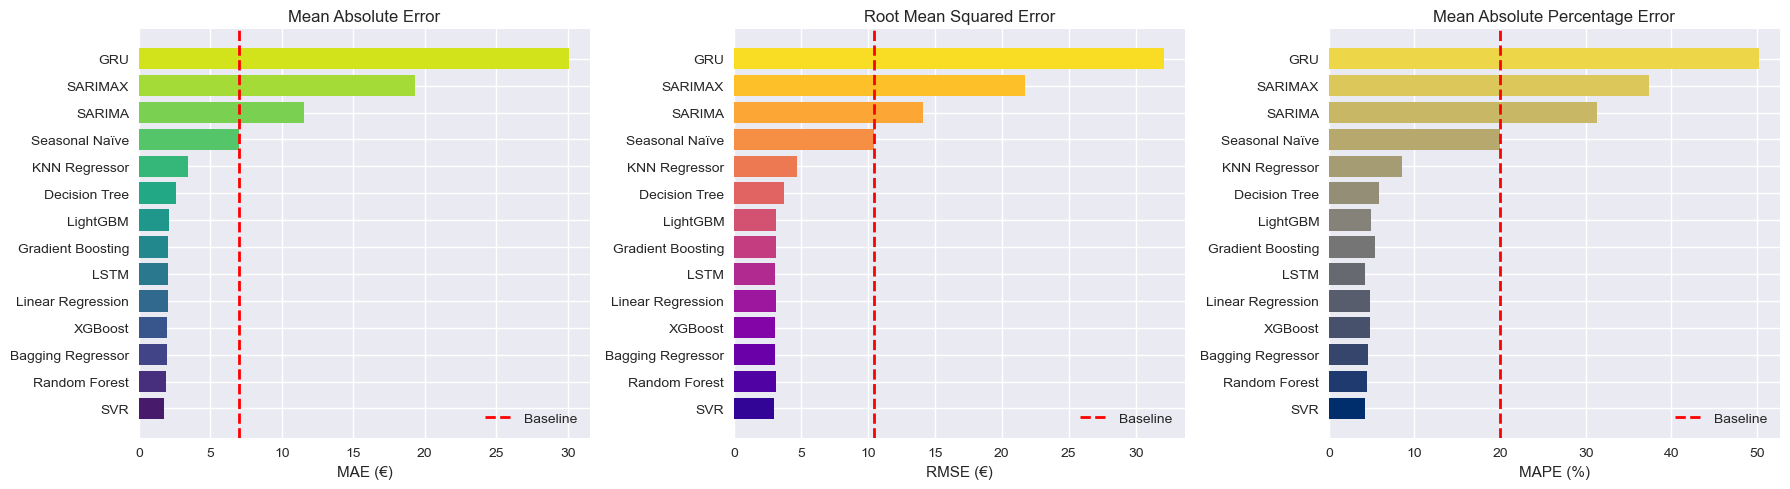

In [67]:
# Gráficos de barras comparativos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MAE
axes[0].barh(df_comparison["Model"], df_comparison["MAE"], 
             color=sns.color_palette("viridis", len(df_comparison)))
axes[0].set_xlabel("MAE (€)")
axes[0].set_title("Mean Absolute Error")
axes[0].axvline(mae_naive, color='red', linestyle='--', label='Baseline', linewidth=2)
axes[0].legend()

# RMSE
axes[1].barh(df_comparison["Model"], df_comparison["RMSE"], 
             color=sns.color_palette("plasma", len(df_comparison)))
axes[1].set_xlabel("RMSE (€)")
axes[1].set_title("Root Mean Squared Error")
axes[1].axvline(rmse_naive, color='red', linestyle='--', label='Baseline', linewidth=2)
axes[1].legend()

# MAPE
axes[2].barh(df_comparison["Model"], df_comparison["MAPE (%)"], 
             color=sns.color_palette("cividis", len(df_comparison)))
axes[2].set_xlabel("MAPE (%)")
axes[2].set_title("Mean Absolute Percentage Error")
axes[2].axvline(mape_naive, color='red', linestyle='--', label='Baseline', linewidth=2)
axes[2].legend()

plt.tight_layout()
plt.show()

### Best Model by Category

In [68]:
# Identificar o melhor modelo por categoria
best_by_category = df_comparison.loc[
    df_comparison.groupby("Category")["MAE"].idxmin()
]

print("\n" + "="*70)
print("BEST MODEL IN EACH CATEGORY (by MAE)")
print("="*70)
display(best_by_category[["Category", "Model", "MAE", "RMSE", "MAPE (%)"]])

# Melhor modelo overall
best_overall = df_comparison.iloc[0]
print("\n" + "="*70)
print("🏆 BEST MODEL OVERALL")
print("="*70)
print(f"Model:     {best_overall['Model']}")
print(f"Category:  {best_overall['Category']}")
print(f"MAE:       {best_overall['MAE']:.4f} €")
print(f"RMSE:      {best_overall['RMSE']:.4f} €")
print(f"MAPE:      {best_overall['MAPE (%)']:.2f} %")
print("="*70)


BEST MODEL IN EACH CATEGORY (by MAE)


Category           Model        MAE       RMSE   MAPE (%)
10          Baseline  Seasonal Naïve   7.010173  10.435525  19.974199
5      Deep Learning            LSTM   2.044885   3.035623   4.252400
0   Machine Learning             SVR   1.757950   2.986804   4.248352
11       Statistical          SARIMA  11.580625  14.144302  31.374124


🏆 BEST MODEL OVERALL
Model:     SVR
Category:  Machine Learning
MAE:       1.7580 €
RMSE:      2.9868 €
MAPE:      4.25 %
